# SPAIN ECONOMIC POLICY UNCERTAINTY INDEX - TIME SERIES FORECASTING

<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/9/9a/Flag_of_Spain.svg" width="150">
</p>


We begin by exploring the Spain Economic Policy Uncertainty (EPU) Index dataset, which spans from 1997 to 2025. Initial checks confirm that there are no missing values or duplicate records, and data types are appropriate: dates, months as integers, and the EPU Index as a continuous numerical feature. Summary statistics show a mean index value around 113 with a minimum near 31 and maximum over 260, hinting at significant variability over time.


### 0. LIBRARIES

In [5]:
%%capture
%pip install plotly statsmodels scikit-learn xgboost pmdarima statsforecast arch

In [6]:
# Core Libraries
import numpy as np
import pandas as pd
import itertools


# Visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.patheffects as pe
import matplotlib as mpl
import seaborn as sns
import matplotlib.ticker as mticker
import seaborn as sns
import plotly.graph_objects as go

# Time Series Analysis & Statistical Models
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
import pmdarima as pm
from scipy.signal import periodogram
from scipy.fft import fft
from scipy import stats

# ARCH/GARCH Models
import arch
from arch import arch_model
from statsforecast import StatsForecast
from statsforecast.models import ARCH, GARCH, Naive

# Machine Learning & Pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, ParameterGrid
from xgboost import XGBRegressor
import xgboost as xgb

# Preprocessing & Feature Engineering
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

# Deep Learning (Keras/Tensorflow)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Utilities
from tqdm import tqdm

# Jupyter Notebook Settings
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


C:\Users\phath\anaconda3\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


### 1. IMPORT DATASET

In [8]:
df = pd.read_excel("NEW_SPAIN_EPU_INDEX.xlsx",skiprows=1)

In [9]:
df.head() 

,Year,Month,Index value
0,1997,1,31.018169
1,1997,2,50.695080
2,1997,3,43.754341
3,1997,4,43.427864
4,1997,5,120.413849


In [10]:
df['Date'] = pd.to_datetime(dict(year=df['Year'], month=df['Month'], day=1))
df = df.set_index('Date').sort_index()
df = df.reset_index()
df = df.drop(columns="Year")
df.tail()

,Date,Month,Index value
335,2024-12-01,12,180.977631
336,2025-01-01,1,191.908890
337,2025-02-01,2,147.651108
338,2025-03-01,3,174.871140
339,2025-04-01,4,212.141449


### 2. EXPLORY DATA ANALYSIS

In [12]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         340 non-null    datetime64[ns]
 1   Month        340 non-null    int64         
 2   Index value  340 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 8.1 KB


,Date,Month,Index value
count,340,340.000000,340.000000
mean,2011-02-15 02:07:03.529411840,6.452941,112.745058
min,1997-01-01 00:00:00,1.000000,31.018169
25%,2004-01-24 06:00:00,3.000000,80.984438
50%,2011-02-15 00:00:00,6.000000,108.462086
75%,2018-03-08 18:00:00,9.000000,140.231647
max,2025-04-01 00:00:00,12.000000,261.609741
std,NaN,3.465909,40.348093


The dataset includes 340 monthly records from 1997 to 2025, with no missing values. The Index value shows considerable variation over time, underlining the need for models that can capture trends, seasonality, and volatility.


In [14]:
def summary(df):
    summary_df = pd.DataFrame(df.dtypes, columns=['dtype'])
    summary_df['missing'] = df.isnull().sum()
    summary_df['duplicates'] = df.duplicated().sum()
    summary_df['missing_per'] = df.isnull().sum() / len(df) * 100
    summary_df['uniques'] = df.nunique().values
    summary_df['count'] = df.count().values
    return summary_df

summary(df).style.background_gradient(cmap='Blues')

,dtype,missing,duplicates,missing_per,uniques,count
Date,datetime64[ns],0,0,0.000000,340,340
Month,int64,0,0,0.000000,12,340
Index value,float64,0,0,0.000000,340,340


A quick overview of the dataset shows no missing or duplicate values, with clear data types and consistent record counts. This confirms data quality for further analysis and modeling.


In [16]:
print("Data shape: ", df.shape)
print(f"Total observations: {len(df)}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

Data shape:  (340, 3)
Total observations: 340
Date range: 1997-01-01 00:00:00 to 2025-04-01 00:00:00


To avoid unwant inplace to default dataset, we copy another df name: eda_df

In [18]:
eda_df = df.copy() #edadatase
eda_df.head()

,Date,Month,Index value
0,1997-01-01,1,31.018169
1,1997-02-01,2,50.695080
2,1997-03-01,3,43.754341
3,1997-04-01,4,43.427864
4,1997-05-01,5,120.413849


--- 
Plotting the EPU Index over time reveals its evolution from 1997 through 2025. Early years show relatively stable and moderate uncertainty levels. Over time, pronounced peaks appear, reflecting periods of intensified economic or political stress. Especially noticeable are sharp increases around 2012 and 2020, aligning with known global and regional crises. This visualization helps us understand the overall trend and long-term shifts in economic policy uncertainty in Spain.

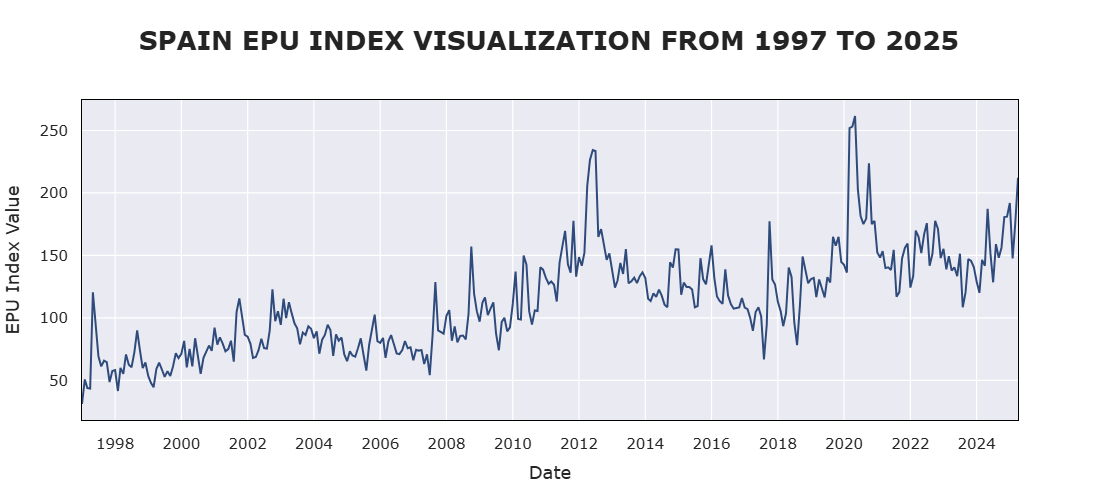

In [20]:
fig = go.Figure()
# testing
fig.add_trace(go.Scatter(
    x=df['Date'],
    y=df['Index value'],
    mode='lines',
    name='EPU Index',
    line=dict(color="#2f4b7c", width=2),
))

fig.update_layout(
    title=dict(
        text='<b>SPAIN EPU INDEX VISUALIZATION FROM 1997 TO 2025</b>',
        x=0.5,
        font=dict(size=26)
    ),
    xaxis_title='Date',
    yaxis_title='EPU Index Value',
    width=1000,
    height=500,
    template='seaborn',
    font=dict(size=15),
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1,
        font=dict(size=15)
    )
)

fig.update_xaxes(
    showgrid=True,
    gridwidth=1.2,
    dtick="M24",
    tickformat="%Y",
    showline=True,
    linewidth=1,
    linecolor='black',
    mirror=True,
    ticklabelstandoff=10 
)

fig.update_yaxes(
    showgrid=True,
    gridwidth=1.2,
    zeroline=True,
    zerolinewidth=1.5,
    showline=True,
    linewidth=1,
    linecolor='black',
    mirror=True,
    ticklabelstandoff=10
)


fig.show()


---
To better capture underlying trends, we apply a 12-month rolling average. This smoothed view highlights periods of sustained high uncertainty. Notably, while short-term fluctuations abound, there is a clear upward drift in the smoothed curve over the years. This suggests that baseline economic policy uncertainty in Spain has gradually increased, moving from lower values in the early 2000s to consistently elevated levels in the 2010s and 2020s.


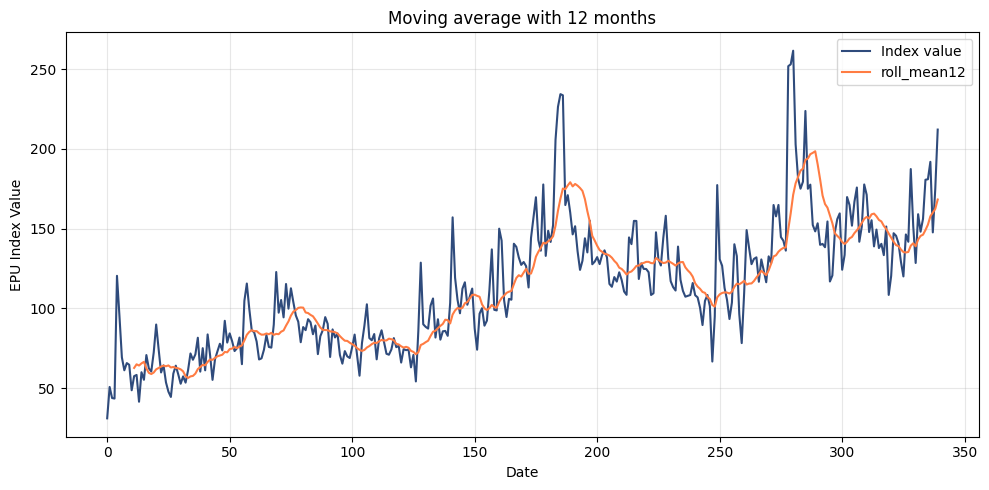

In [22]:
colors = ['#2f4b7c', '#ff7c43']
eda_df["roll_mean12"] = eda_df["Index value"].rolling(12).mean()
eda_df[['Index value', 'roll_mean12']].plot(
    figsize=(10, 5),
    linewidth=1.5,
    color=colors,
    title="Moving average with 12 months"
)

plt.grid(alpha=0.3)
plt.xlabel("Date")
plt.ylabel("EPU Index Value")
plt.tight_layout()
plt.show()

--- 
Examining the distribution of the EPU Index shows a right-skewed shape, with most observations clustering between 50 and 150 but with a long tail of high values. This confirms that while moderate uncertainty is typical, there are occasional extreme events driving the index to much higher levels. Understanding this skew is important for modeling and forecasting, as these rare but impactful spikes can heavily influence mean values and volatility. 

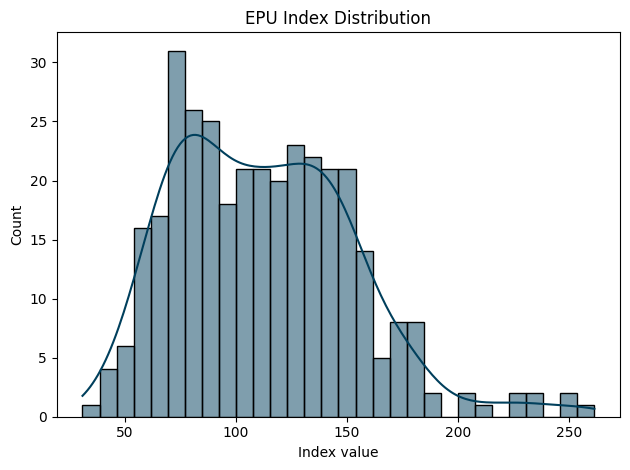

In [24]:
sns.histplot(
    eda_df['Index value'],
    bins=30,
    kde=True,
    color='#003f5c'
)

plt.title("EPU Index Distribution")
plt.tight_layout()
plt.show()


In general:
- Wide, multi-modal distribution with mild left-skew.
- Most values ~80–150 but some very high outliers.
- Suggests different regimes and crisis periods.
- Modeling should account for variability and outliers.

--- 
A box plot further illustrates the distribution's spread and highlights the presence of outliers. Most values lie below approximately 220, with clear outlier points beyond this threshold. These outliers reflect periods of exceptional economic policy uncertainty that could strongly influence forecasting models. Identifying and managing these points is essential in preprocessing and modeling phases.

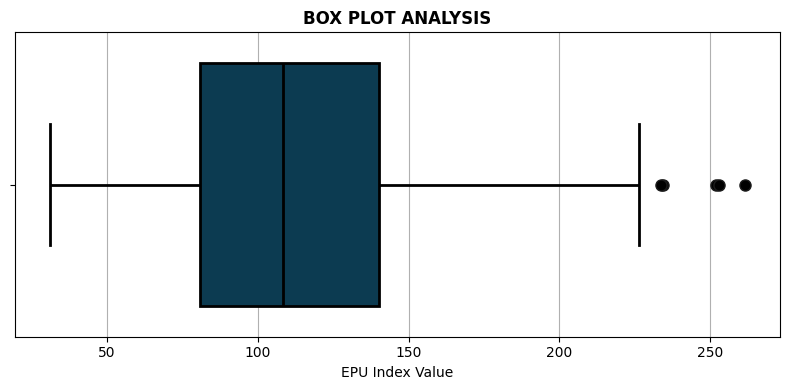

5th percentile: 58.21
10th percentile: 65.65
25th percentile: 80.98
50th percentile: 108.46
75th percentile: 140.23
90th percentile: 159.63
95th percentile: 177.71


In [27]:
plt.figure(figsize=(8, 4))
sns.boxplot(
    x=eda_df['Index value'],
    orient='h',
    color='#003f5c',
    boxprops=dict(edgecolor="black", linewidth=2),
    medianprops=dict(color='black', linewidth=2),
    whiskerprops=dict(color='black', linewidth=2),
    capprops=dict(color='black', linewidth=2),
    flierprops=dict(markerfacecolor='black', marker='o', markersize=8, linestyle='none')
)

plt.title("BOX PLOT ANALYSIS", fontweight='bold')
plt.xlabel("EPU Index Value")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

percentiles = [5, 10, 25, 50, 75, 90, 95]
for p in percentiles:
    value = np.percentile(df['Index value'], p) 
    print(f"{p}th percentile: {value:.2f}")


**Why are there outliers in the Spain EPU Index?**

- They reflect real events (not noise).
- Driven by crises: 2008 Financial Crisis, Euro Debt Crisis, COVID-19, Ukraine-Russia War.
- Show sharp jumps in policy uncertainty during extreme shocks.
- Important signals for forecasting and risk analysis.

**With all the crise can be illustrated by the crisis chart and outliers point chart below**

---
We further annotate the time series with shaded bands for key crisis periods: the 2008 Financial Crisis, European Debt Crisis, COVID-19 Pandemic, and Ukraine-Russia War. These visual markers help link observed index spikes with real-world events. By mapping crises onto the index, we see clear patterns of heightened uncertainty during global and regional shocks. This context is vital for interpreting model forecasts and potential policy responses.

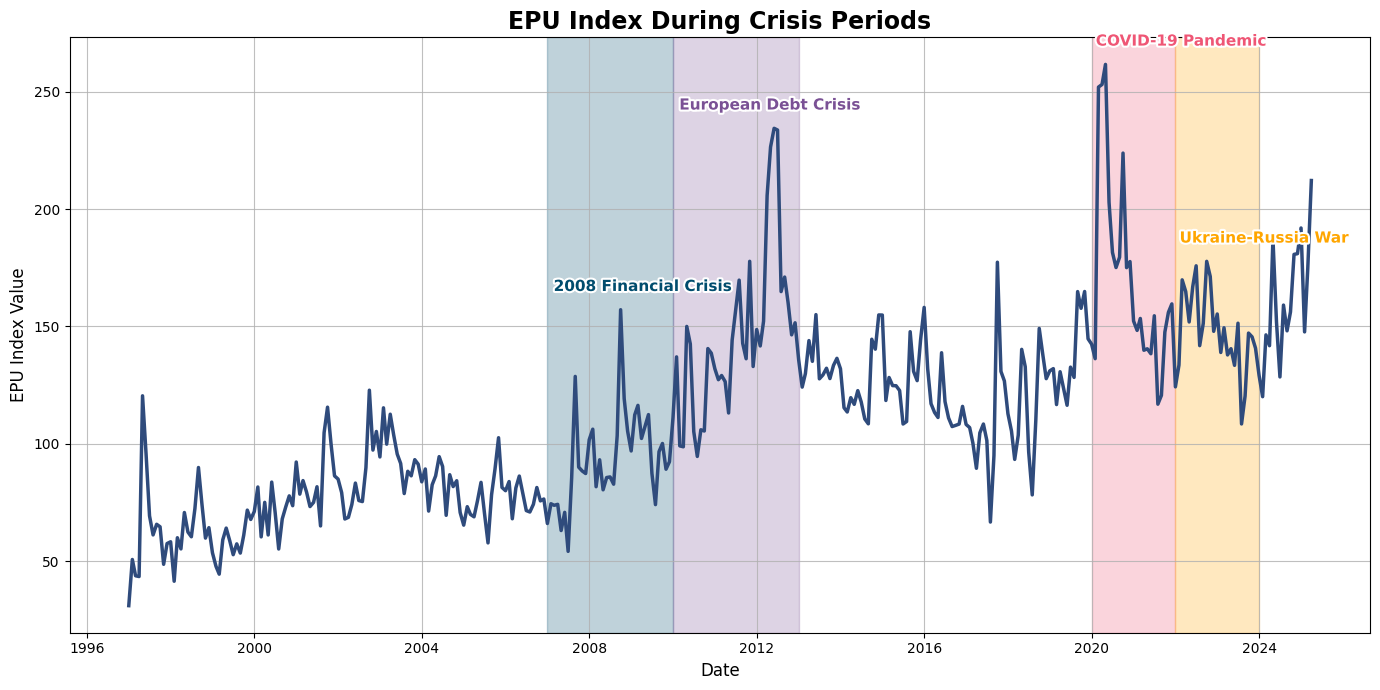

In [30]:
crisis_periods = {
    '2008 Financial Crisis': ('2007-01-01', '2009-12-31'),
    'European Debt Crisis': ('2010-01-01', '2012-12-31'),
    'COVID-19 Pandemic': ('2020-01-01', '2021-12-31'),
    'Ukraine-Russia War': ('2022-01-01', '2023-12-31')
}
highlight_colors = ["#004c6d", "#7a5195", "#ef5675", "#ffa600"]

plt.figure(figsize=(14, 7))


plt.plot(eda_df['Date'], eda_df['Index value'],
         color="#2f4b7c", linewidth=2.5,
         label="EPU Index", zorder=3)

for i, (crisis, (start, end)) in enumerate(crisis_periods.items()):
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)
    crisis_data = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    
    if not crisis_data.empty:
        plt.axvspan(
            start_date, end_date,
            color=highlight_colors[i],
            alpha=0.25,  
        )
        plt.text(
            x=start_date + (end_date - start_date) / 20,
            y=crisis_data['Index value'].max() + 8,
            s=crisis,
            fontsize=11,
            color=highlight_colors[i],
            fontweight='bold',
            path_effects=[pe.withStroke(linewidth=3, foreground="white")],
            zorder=5
        )
plt.title("EPU Index During Crisis Periods", fontsize=17, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("EPU Index Value", fontsize=12)
plt.grid(alpha=0.8)
plt.tight_layout()
plt.show()


We explicitly identify outlier points above the upper interquartile threshold (using 1.5*IQR). Plotting these on the time series reveals that outliers correspond to major crisis periods. For example, spikes around 2012 and 2020 are visually highlighted, aligning with the European Debt Crisis and the COVID-19 Pandemic. This step is crucial in understanding model behavior and informing robust preprocessing strategies.

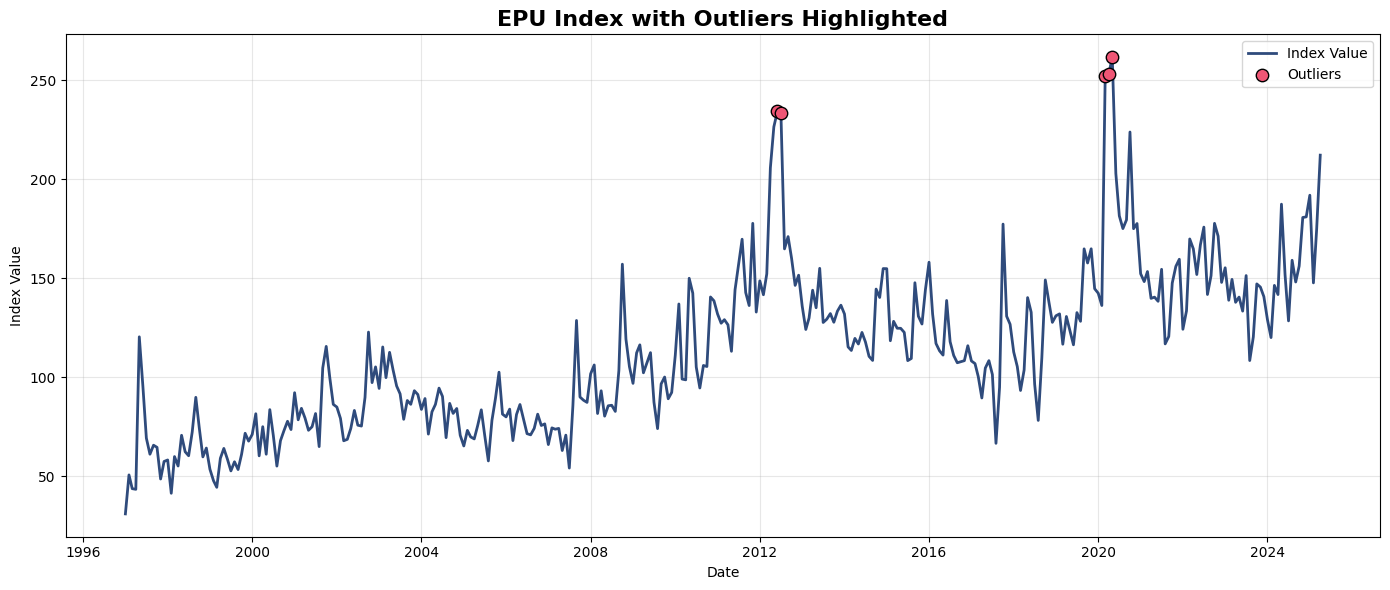

In [32]:
q1 = eda_df['Index value'].quantile(0.25)
q3 = eda_df['Index value'].quantile(0.75)
iqr = q3 - q1
upper = q3 + 1.5 * iqr

# Tìm outliers
outliers = eda_df[eda_df['Index value'] > upper]
plt.figure(figsize=(14, 6))
plt.plot(
    eda_df['Date'], eda_df['Index value'],
    color="#2f4b7c", linewidth=2, label='Index Value'
)
plt.scatter(
    outliers['Date'], outliers['Index value'],
    color="#ef5675", edgecolor='black', s=80, zorder=5, label='Outliers'
)
plt.title('EPU Index with Outliers Highlighted', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


---
Also, a violin plot compares EPU Index distributions across decades. The 1990s and 2000s show tighter, lower-centered distributions, suggesting relatively stable and moderate uncertainty. In contrast, the 2010s and 2020s exhibit broader spreads and higher medians, reflecting increased uncertainty and more frequent extreme values. This progression underscores how Spain's economic policy environment has become more volatile over time, and it highlights the importance of using models capable of capturing these structural shifts.

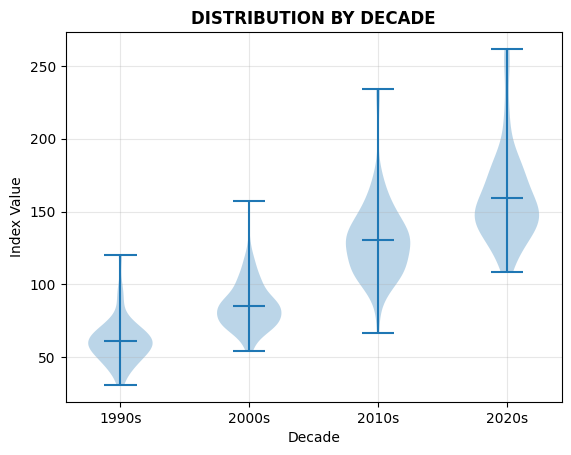

In [34]:
eda_df['Year'] = eda_df['Date'].dt.year
eda_df['Decade'] = (eda_df['Year'] // 10) * 10
decades = sorted(eda_df['Decade'].unique())
decade_data = [eda_df[eda_df['Decade'] == d]['Index value'] for d in decades]
violin_parts = plt.violinplot(decade_data, positions=range(len(decades)), showmeans=True)
plt.xticks(range(len(decades)))
plt.xticks(range(len(decades)), [f"{int(d)}s" for d in decades])
plt.title('DISTRIBUTION BY DECADE', fontweight='bold')
plt.xlabel('Decade')
plt.ylabel('Index Value')
plt.grid(True, alpha=0.3)
plt.show();

To explore intra-year seasonality, we analyze average EPU Index values by month. The bar chart reveals a clear pattern: uncertainty tends to be slightly lower during summer months like July and August, and higher during autumn, with October peaking at over 123 on average. This suggests that policy uncertainty in Spain is not uniformly distributed throughout the year but shows systematic seasonal variations. These cyclical effects can be important features for forecasting models, as they reflect regular economic rhythms tied to legislative cycles, budgeting periods, or business activity.

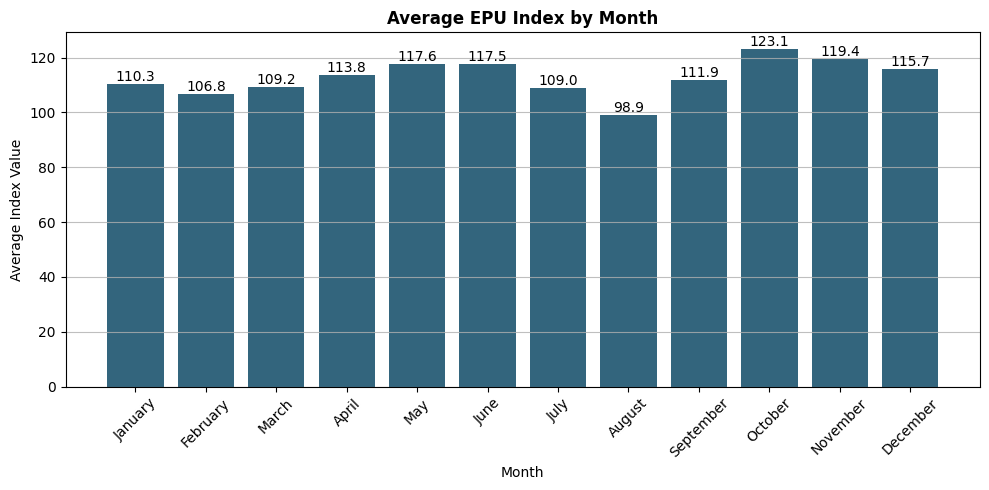

In [36]:
eda_df['Month'] = eda_df['Date'].dt.month
eda_df['Month_Name'] = eda_df['Date'].dt.month_name()

monthly_stats = eda_df.groupby('Month').agg(mean=('Index value', 'mean'), std=('Index value', 'std')).reset_index()
monthly_stats['Month_Name'] = pd.to_datetime(monthly_stats['Month'], format='%m').dt.month_name()

plt.figure(figsize=(10, 5))
bars = plt.bar(monthly_stats['Month_Name'], monthly_stats['mean'], color='#003f5c', alpha=0.8)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}', ha='center', va='bottom', fontsize=10)

plt.title('Average EPU Index by Month', fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Average Index Value')
plt.xticks(rotation=45)
plt.grid(True, axis='y', alpha = 0.8)
plt.tight_layout()
plt.show()


---

After examining monthly seasonality, we turn to quarterly averages to confirm broader patterns in Spain's Economic Policy Uncertainty. The chart of average EPU Index by quarter reinforces our previous observations: Q3 consistently shows the lowest uncertainty (around 106), while Q4 peaks at nearly 120.

This seasonal behavior aligns with typical economic cycles—summer months (Q3) often see reduced political activity and fewer major announcements, while year-end (Q4) is marked by budget approvals and policy planning, heightening uncertainty. 

Recognizing these quarterly patterns is essential for modeling, as it captures systematic fluctuations that can improve forecast accuracy. Including quarterly seasonality terms or time-based dummy variables in statistical and machine learning models can help anticipate these predictable variations, reducing forecast error and supporting better decision-making for policymakers and businesses alike.


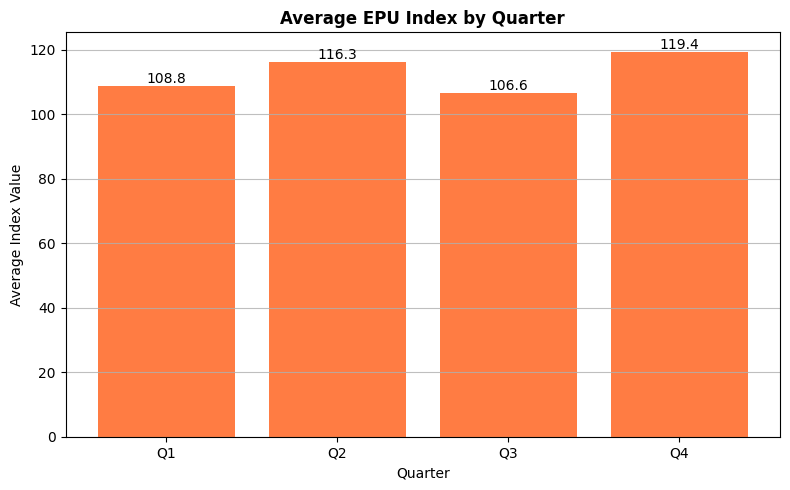

In [38]:
eda_df['Quarter'] = eda_df['Date'].dt.quarter
quarterly_stats = eda_df.groupby('Quarter')['Index value'].mean().reset_index()

plt.figure(figsize=(8, 5))
bars = plt.bar(quarterly_stats['Quarter'], quarterly_stats['Index value'], color='#ff7c43')

# Annotate
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}', ha='center', va='bottom', fontsize=10)

plt.title('Average EPU Index by Quarter', fontweight='bold')
plt.xlabel('Quarter')
plt.ylabel('Average Index Value')
plt.xticks([1, 2, 3, 4], ['Q1', 'Q2', 'Q3', 'Q4'])
plt.grid(True, axis='y', alpha=0.8)
plt.tight_layout()
plt.show()

---

Following the year-over-year change analysis, the 12-month rolling volatility chart offers another key perspective on Spain's EPU Index. It shows periods of heightened uncertainty, especially during major crises like 2008, the European Debt Crisis, and COVID-19.

These spikes highlight not only increases in the index level but also in its variability—important for modeling since volatility can shift dramatically over time. This insight supports the use of models like ARCH/GARCH and justifies including rolling standard deviation as a feature to help capture changing risk and improve forecast robustness.

Together, this volatility view complements our earlier trend and seasonality analyses, giving us a more complete picture for effective predictive modeling.


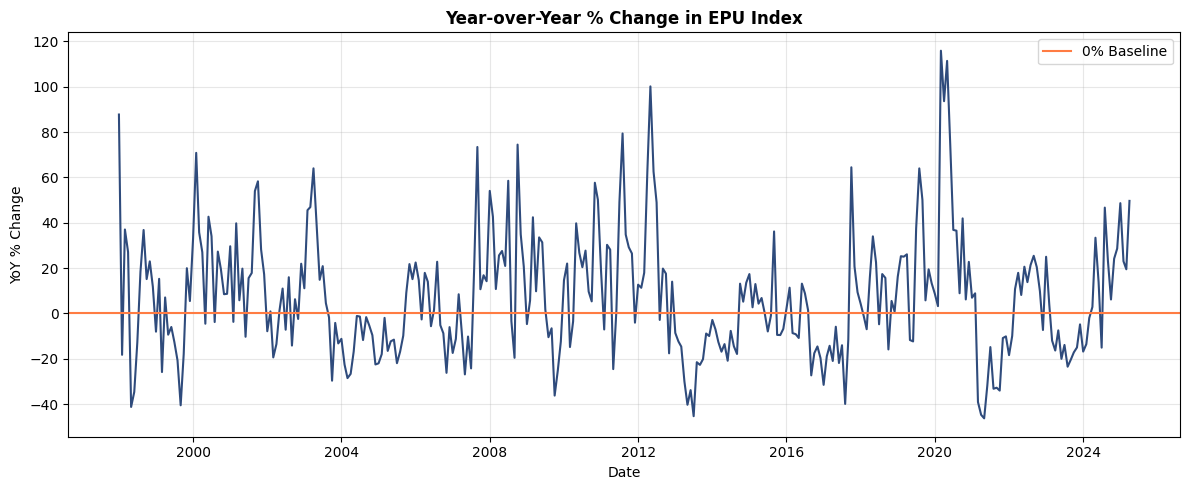

In [40]:
df_sorted = eda_df.sort_values(by='Date').copy()
df_sorted['YoY_Change'] = df_sorted['Index value'].pct_change(periods=12) * 100

plt.figure(figsize=(12, 5))
plt.plot(df_sorted['Date'], df_sorted['YoY_Change'], color='#2f4b7c', linewidth=1.5)
plt.axhline(0, color='#ff7c43', linestyle='-', label='0% Baseline')
plt.title('Year-over-Year % Change in EPU Index', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('YoY % Change')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


---

The 12-month rolling volatility chart refines our view of the EPU Index by tracking its changing variability over time. Noticeable peaks align with major crises, reinforcing the idea that uncertainty isn't constant but clustered in volatile periods.

This emphasizes the value of volatility features and models that can adapt to such shifts, supporting better forecasting and risk management.



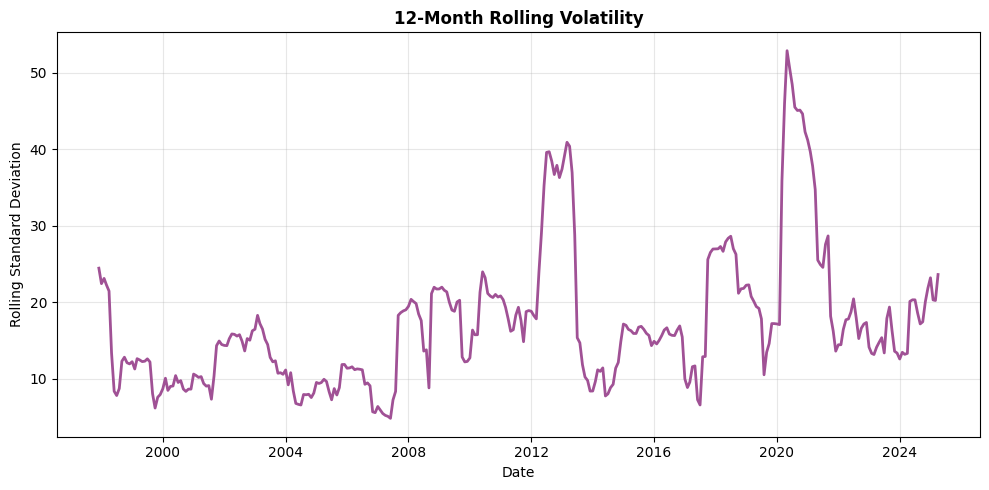

In [42]:
rolling_vol = eda_df.set_index('Date')['Index value'].rolling(window=12).std()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(rolling_vol.index, rolling_vol.values, color="#a05195", linewidth=2)

ax.set_title('12-Month Rolling Volatility', fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Rolling Standard Deviation')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


---

The heatmap shows strong autocorrelations for short-term lags like 1 and 2, as well as 6 and 12 months. These lags capture both immediate and seasonal dependencies, guiding feature selection for time series models.

<Axes: >

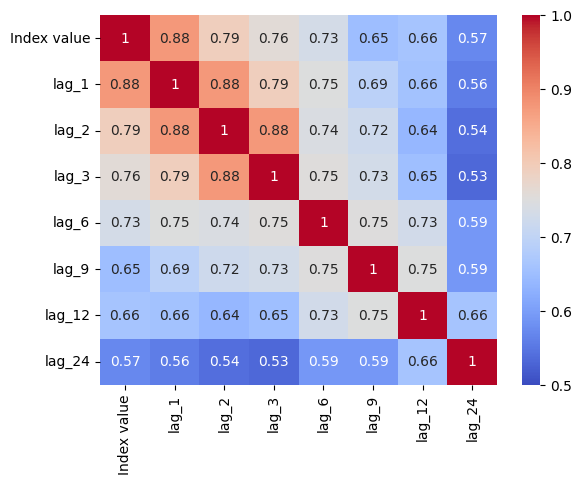

In [44]:
for lag in [1, 2, 3, 6, 9, 12, 24]:
    eda_df[f'lag_{lag}'] = eda_df['Index value'].shift(lag)
corr = eda_df[['Index value', 'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_9', 'lag_12', 'lag_24']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=0.5)

---
This heatmap continues the story of strong seasonality seen in the monthly and quarterly bar charts. It shows monthly EPU values across years, highlighting not only crisis spikes but also recurring seasonal patterns. These visible monthly cycles reinforce why incorporating month as a feature or seasonal terms in models like SARIMA is crucial for capturing EPU's temporal dynamics.

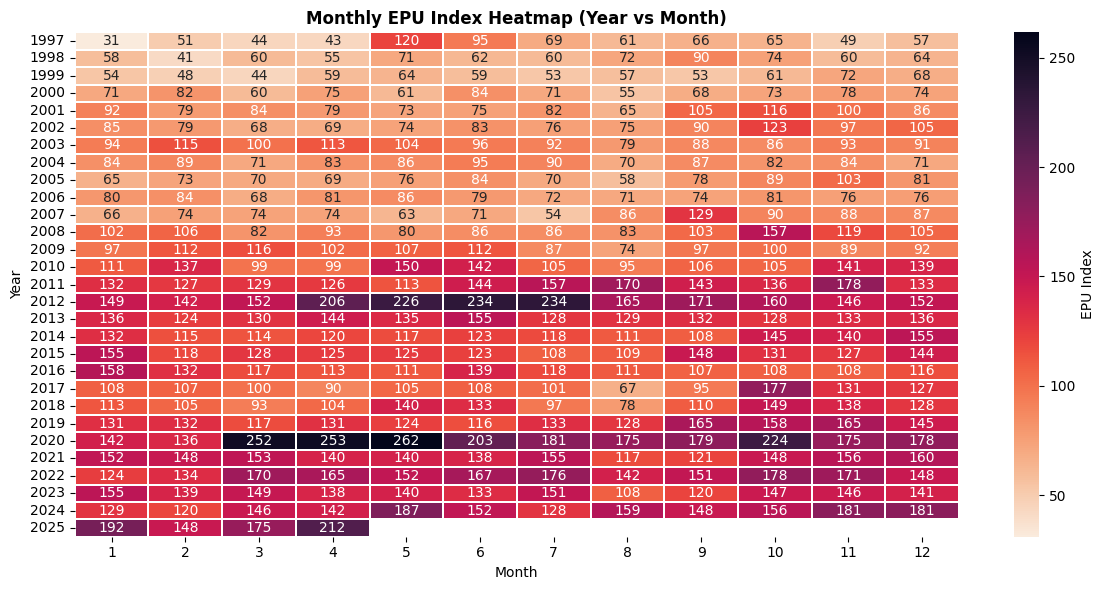

In [46]:
pivot = df.pivot_table(
    index=df['Date'].dt.year,
    columns=df['Date'].dt.month,
    values='Index value',
    aggfunc='mean'
)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap="rocket_r", annot=True, fmt=".0f", linewidths=0.3, cbar_kws={'label': 'EPU Index'})
plt.title("Monthly EPU Index Heatmap (Year vs Month)", fontweight='bold')
plt.xlabel("Month")
plt.ylabel("Year")
plt.tight_layout()
plt.show()


### 3. DATA PREPROCESSING

In [48]:
df_sorted = df.sort_values('Date')
date_diff = df_sorted['Date'].diff().dt.days.dropna()

In [49]:
df['Month'] = df['Month'].astype(int)
df['Index value'] = df['Index value'].astype(float)

In [50]:
for col in df.columns:
    missing_data = df[col].isna().sum()
    missing_per = missing_data /len(df)*100
    print(f"Column {col} has {missing_per}% missing data")

Column Date has 0.0% missing data
Column Month has 0.0% missing data
Column Index value has 0.0% missing data


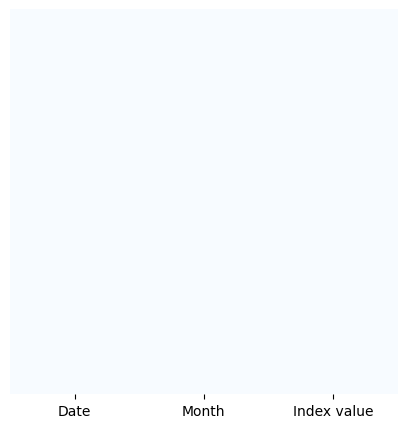

In [51]:
plt.figure(figsize = (5,5))
sns.heatmap(df.isna(), cbar = False, cmap = "Blues", yticklabels = False )
plt.show();

In [52]:
df.dropna(inplace=True)

In [53]:
def check_stationarity(series, p_significant=0.05):
    adfuller_result = adfuller(series)
    kpss_result = kpss(series)

    print(f'ADF Statistic : {adfuller_result[0]:.5f}, p-value: {adfuller_result[1]:.5f}')
    print('Critical Values:')
    for key, value in adfuller_result[4].items():
        print('\t%s: %.3f' % (key, value))
    print(f'KPSS Statistic: {kpss_result[0]:.5f}, p-value: {kpss_result[1]:.5f}')
    if (adfuller_result[1] <= p_significant) & (adfuller_result[4]['5%'] > adfuller_result[0]) & (kpss_result[1] > p_significant):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [54]:
check_stationarity(df["Index value"])

ADF Statistic : -1.52967, p-value: 0.51879
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
KPSS Statistic: 2.35393, p-value: 0.01000
Non-stationary


In [55]:
diff = df['Index value'].diff(1).dropna()

In [56]:
check_stationarity(diff)

ADF Statistic : -7.95110, p-value: 0.00000
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
KPSS Statistic: 0.12544, p-value: 0.10000
Stationary


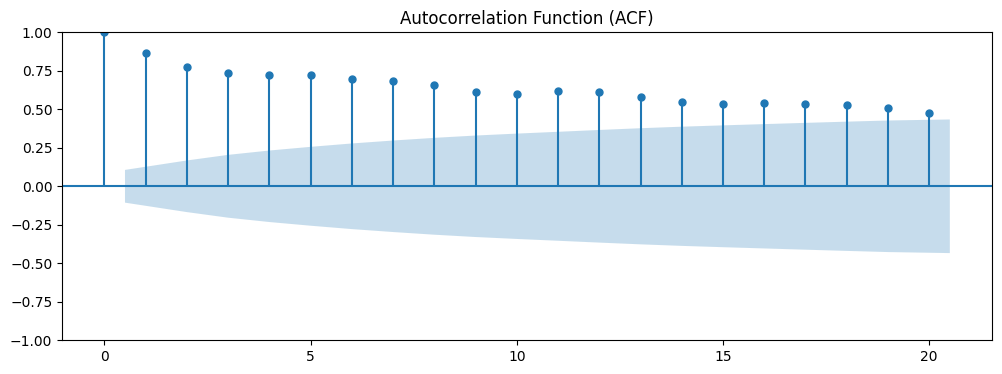

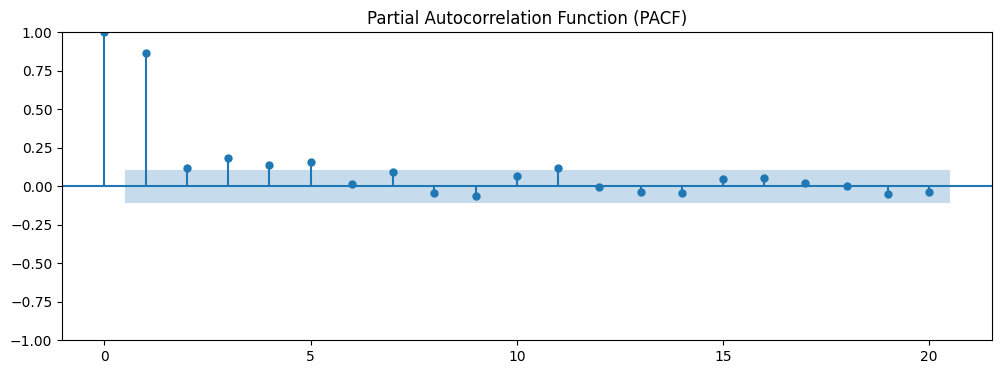

In [57]:
# Plot the ACF
fig_acf = plot_acf(df['Index value'], lags=20, title='Autocorrelation Function (ACF)')
fig_acf.set_size_inches(12,4)
plt.show();

# Plot the PACF
fig_pacf = plot_pacf(df['Index value'], lags=20, title='Partial Autocorrelation Function (PACF)')
fig_pacf.set_size_inches(12,4)
plt.show();

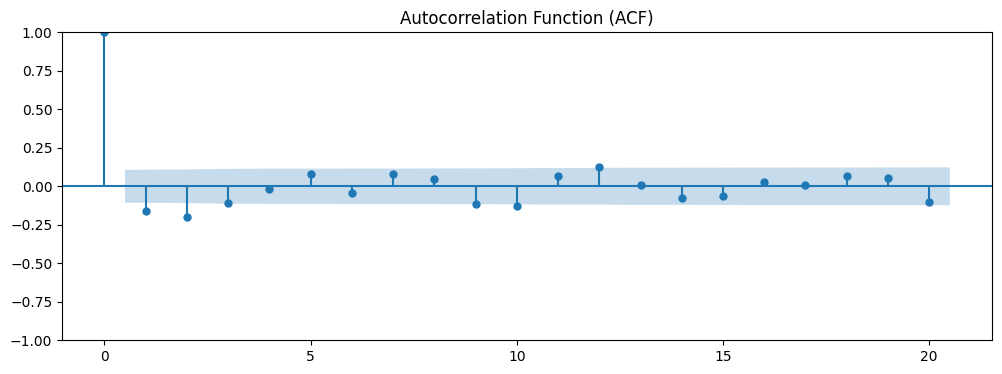

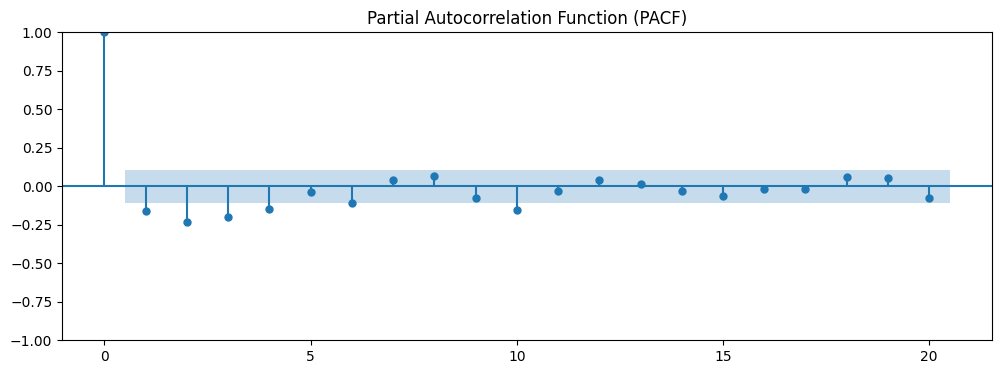

In [58]:
# Plot the ACF
fig_acf = plot_acf(diff, lags=20, title='Autocorrelation Function (ACF)')
fig_acf.set_size_inches(12,4)
plt.show();

# Plot the PACF
fig_pacf = plot_pacf(diff, lags=20, title='Partial Autocorrelation Function (PACF)')
fig_pacf.set_size_inches(12,4)
plt.show();


**ADF and KPSS Tests**:
  - The original EPU Index series is **non-stationary**, with clear trends and crisis-driven shifts.
  - After **first differencing**, it becomes **stationary** and shows no significant autocorrelation, making it suitable for ARIMA/SARIMA with d=1.

**ACF and PACF Analysis**:
  - Autocorrelations decline sharply after differencing.
  - No significant coefficients appear beyond lag 0, indicating a **random walk** behavior.
  - Confirms the first-differenced series is stationary and uncorrelated, simplifying choice of p and q.

**Conclusion**: These tests and plots ensure the series meets ARIMA/SARIMA assumptions, supporting more robust EPU Index forecasting.


### 4. FEATURE ENGINEERING


To improve forecasting accuracy, feature engineering transforms the raw EPU Index data into a richer set of predictive inputs. This step follows **stationarity checks** and **outlier analysis**, ensuring the data is well-prepared for modeling.

**`fe_df` includes:**

- **Date**: Monthly time index.
- **Month**: Encodes seasonality patterns.
- **Index value**: Original EPU Index.
- **Rolling Mean/Std (12 months)**: Captures long-term trend and volatility, essential for modeling uncertainty.
- **Lags (1, 2, 6, 12)**: Adds temporal dependencies identified via ACF/PACF analysis.

These features help models learn seasonality, trend, volatility, and autoregressive structure—building on insights from stationarity tests and autocorrelation plots—to deliver more reliable EPU Index forecasts.


In [62]:
class EPUFeaturePipeline:
    def __init__(
        self,
        target_column: str,
        date_column: str = 'Date',
        lags: list[int] = [1, 2, 6, 12],
        windows: list[int] = [3, 6, 12],
        shock_events: dict[str, tuple[str,str]] = {
            'crisis_2012': ('2012-06-01', '2012-07-31'),
            'covid_2020':  ('2020-03-01', '2020-05-31'),
        }
    ):
        self.target_column = target_column
        self.date_column   = date_column
        self.lags          = lags
        self.windows       = windows
        self.shock_events  = shock_events

    def run_pipeline(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        if self.date_column not in df.columns:
            df = df.reset_index()
        df = self._create_date_features(df)
        df = self._create_lag_features(df)
        df = self._create_rolling_features(df)
        df = self._create_fourier_features(df)
        df = self._create_shock_dummies(df)
        df = df.dropna().reset_index(drop=True)
        return df

    def _create_date_features(self, df: pd.DataFrame) -> pd.DataFrame:
        df[self.date_column] = pd.to_datetime(df[self.date_column])
        df['month']   = df[self.date_column].dt.month
        df['quarter'] = df[self.date_column].dt.quarter
        df['year']    = df[self.date_column].dt.year
        df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
        df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)

        return df

    def _create_lag_features(self, df: pd.DataFrame) -> pd.DataFrame:
        for lag in self.lags:
            df[f'lag_{lag}'] = df[self.target_column].shift(lag)
        return df

    def _create_rolling_features(self, df: pd.DataFrame) -> pd.DataFrame:
        for w in self.windows:
            df[f'roll_mean_{w}'] = df[self.target_column].rolling(window=w).mean()
            df[f'roll_std_{w}']  = df[self.target_column].rolling(window=w).std()
        return df

    def _create_fourier_features(self, df: pd.DataFrame) -> pd.DataFrame:
        vals = df[self.target_column].fillna(0).values
        ft   = fft(vals)
        df['fft_real'] = np.real(ft)
        df['fft_imag'] = np.imag(ft)
        return df

    def _create_shock_dummies(self, df: pd.DataFrame) -> pd.DataFrame:
        dates = df[self.date_column]
        for name, (start, end) in self.shock_events.items():
            mask = (dates >= pd.to_datetime(start)) & (dates <= pd.to_datetime(end))
            df[name] = mask.astype(int)
        return df


In [63]:
pipeline = EPUFeaturePipeline(target_column='Index value')
fe_df = pipeline.run_pipeline(df)

In [64]:
fe_df 

,Date,Month,Index value,month,quarter,year,sin_month,cos_month,lag_1,lag_2,...,roll_mean_3,roll_std_3,roll_mean_6,roll_std_6,roll_mean_12,roll_std_12,fft_real,fft_imag,crisis_2012,covid_2020
0,1998-01-01,1,58.237976,1,1,1998,5.000000e-01,8.660254e-01,57.480297,48.632679,...,54.783651,5.340352,59.301588,6.176252,64.904826,22.411431,477.863251,1383.976126,0,0
1,1998-02-01,2,41.429329,2,1,1998,8.660254e-01,5.000000e-01,58.237976,57.480297,...,52.382534,9.493316,56.013945,9.400646,64.132680,23.094710,289.105875,1136.776474,0,0
2,1998-03-01,3,59.954559,3,1,1998,1.000000e+00,6.123234e-17,41.429329,58.237976,...,53.207288,10.236059,55.058537,8.465744,65.482698,22.253358,-816.665310,994.429992,0,0
3,1998-04-01,4,55.191563,4,2,1998,8.660254e-01,-5.000000e-01,59.954559,41.429329,...,52.191817,9.620026,53.487734,7.102182,66.463006,21.437629,-243.592858,-142.480593,0,0
4,1998-05-01,5,70.704224,5,2,1998,5.000000e-01,-8.660254e-01,55.191563,59.954559,...,61.950115,7.946530,57.166325,9.421769,62.320538,13.337116,-218.710056,333.937526,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,2024-12-01,12,180.977631,12,4,2024,-2.449294e-16,1.000000e+00,180.674820,156.164917,...,172.605789,14.239018,158.908038,20.058688,152.491599,21.804710,905.009288,-647.049103,0,0
324,2025-01-01,1,191.908890,1,1,2025,5.000000e-01,8.660254e-01,180.977631,180.674820,...,184.520447,6.400370,169.481445,17.340476,157.725259,23.175208,229.739352,-188.672434,0,0
325,2025-02-01,2,147.651108,2,1,2025,8.660254e-01,5.000000e-01,191.908890,180.977631,...,173.512543,23.053925,167.579834,19.234017,160.026471,20.283214,-2525.005739,-3287.850575,0,0
326,2025-03-01,3,174.871140,3,1,2025,1.000000e+00,6.123234e-17,147.651108,191.908890,...,171.477046,22.323255,172.041417,16.757481,162.400931,20.207813,1282.251094,-2039.467416,0,0


### 5. MODELLING

#### 5.0. TIME SERIES DECOMPOSITION

In [67]:
series = df["Index value"]; series

0       31.018169
1       50.695080
2       43.754341
3       43.427864
4      120.413849
          ...    
335    180.977631
336    191.908890
337    147.651108
338    174.871140
339    212.141449
Name: Index value, Length: 340, dtype: float64

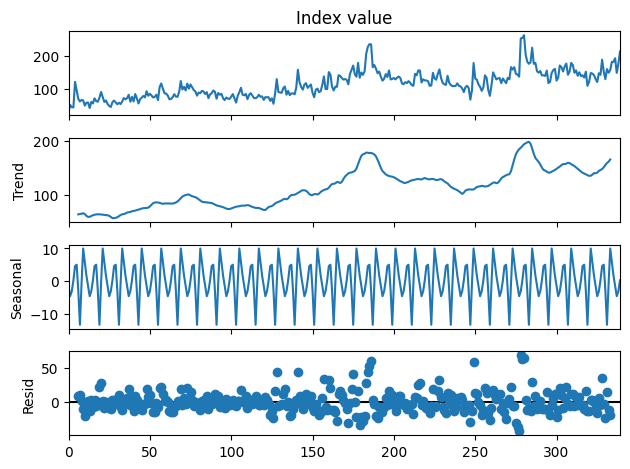

In [68]:
result = seasonal_decompose(series, model="additive", period=12)
result.plot();

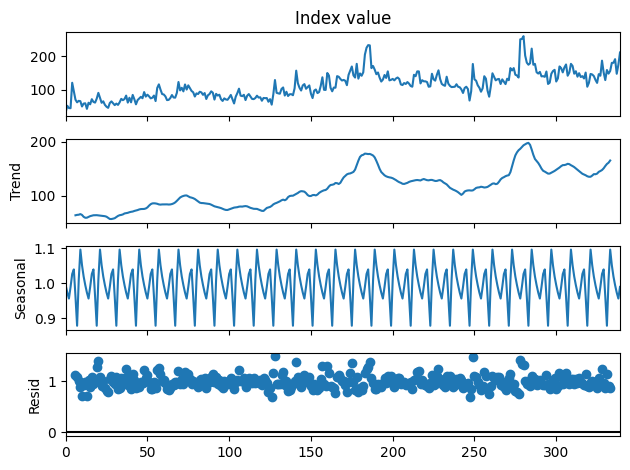

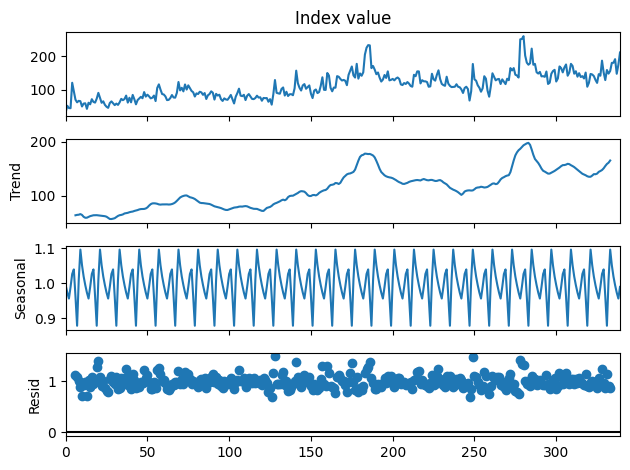

In [69]:
results_multi = seasonal_decompose(series, model="multiplicative", period=12)
results_multi.plot()

<Axes: ylabel='Index value'>

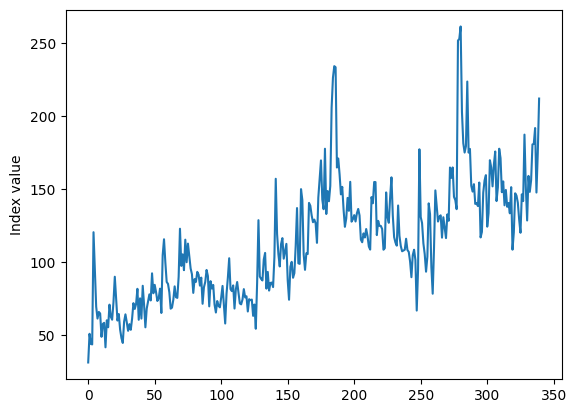

In [70]:
sns.lineplot(series)

<Axes: ylabel='trend'>

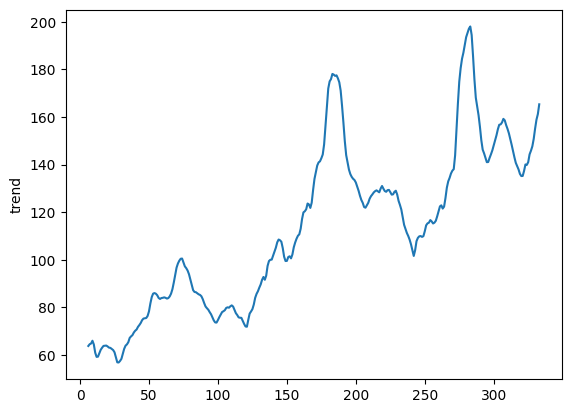

In [71]:
tr = result.trend
sns.lineplot(tr)

#### 5.1. MOVING AVERAGE

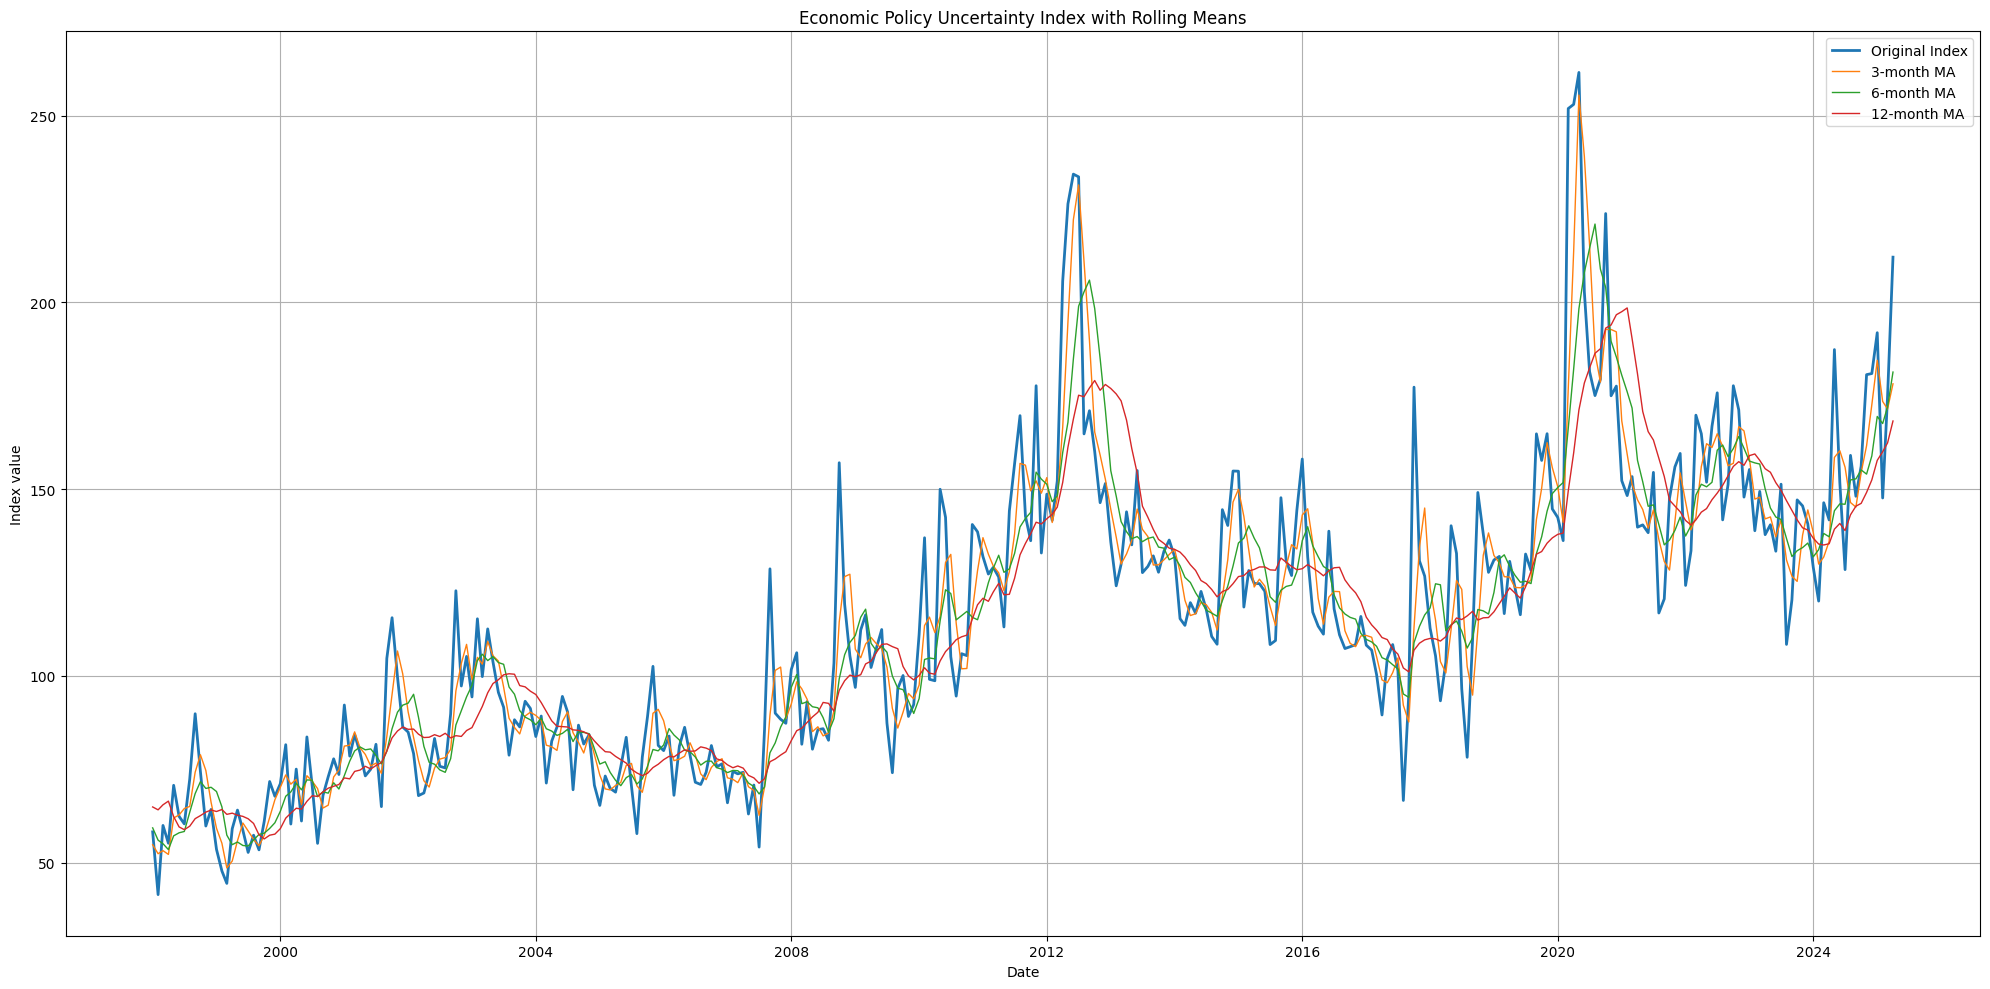

In [73]:
plt.figure(figsize=(20, 10))
plt.plot(fe_df['Date'], fe_df['Index value'], label='Original Index', linewidth=2)
plt.plot(fe_df['Date'], fe_df['roll_mean_3'], label='3-month MA', linewidth=1)
plt.plot(fe_df['Date'], fe_df['roll_mean_6'], label='6-month MA', linewidth=1)
plt.plot(fe_df['Date'], fe_df['roll_mean_12'], label='12-month MA', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Index value')
plt.title('Economic Policy Uncertainty Index with Rolling Means')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [74]:
n_test = 12

train, test = fe_df['Index value'][:-n_test], fe_df['Index value'][-n_test:]
dates_test   = fe_df['Date'][-n_test:]

In [75]:

results = []
y_true = test.values
for w in [3, 6, 12]:
    # forecast
    preds = [fe_df['Index value'].iloc[max(0,i-w):i].mean()
             for i in range(len(train), len(train)+len(test))]
    y_pred = np.array(preds)

    # metrics
    rmse = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100

    results.append({'window': w, 'RMSE': rmse, 'MAE': mae, 'MAPE (%)': mape})

metrics_df = pd.DataFrame(results).set_index('window')
print(metrics_df)


              RMSE        MAE   MAPE (%)
window                                  
3       689.676216  20.788323  12.243745
6       640.494979  20.902687  11.904563
12      842.421013  24.419754  13.702740


#### 5.2. EXPONENTIAL SMOOTHING

##### 5.2.1. SINGLE EXPONENTIAL SMOOTHING

In [78]:
model = SimpleExpSmoothing(series).fit(smoothing_level=0.3, optimized=False)
fitted_values = model.fittedvalues

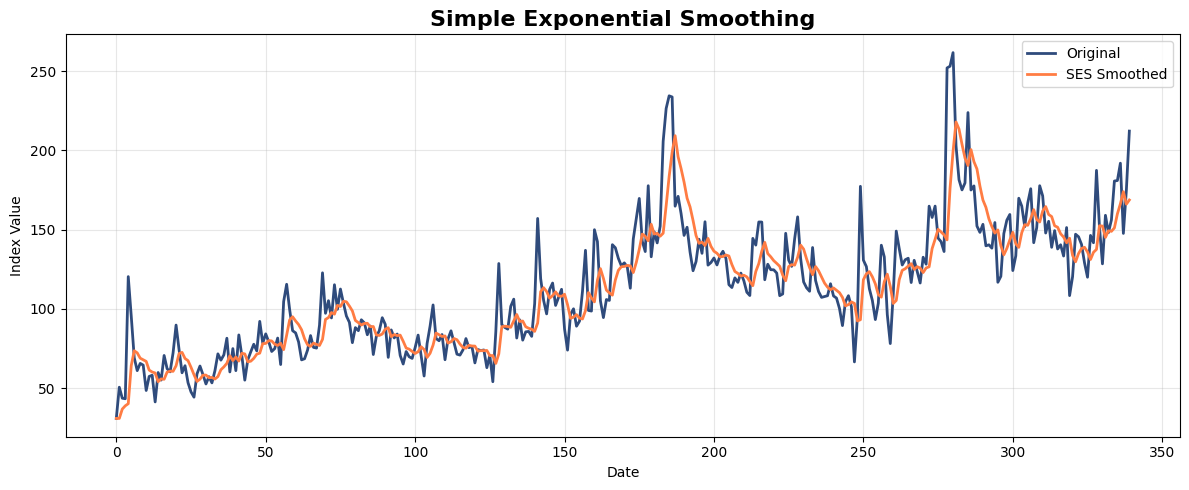

In [79]:
plt.figure(figsize=(12, 5))
plt.plot(series, label='Original', color='#2f4b7c', linewidth=2)
plt.plot(fitted_values, label='SES Smoothed', color='#ff7c43', linewidth=2)
plt.title('Simple Exponential Smoothing', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [80]:
n = len(series)
split_idx = int(0.8 * n)
train = series.iloc[:split_idx]
test = series.iloc[split_idx:]
print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 272, Test size: 68


In [81]:
model = SimpleExpSmoothing(train).fit(optimized=True)
print(f"Smoothing Level (alpha): {model.model.params['smoothing_level']:.3f}")

Smoothing Level (alpha): 0.602


In [82]:
fitted_train = model.fittedvalues

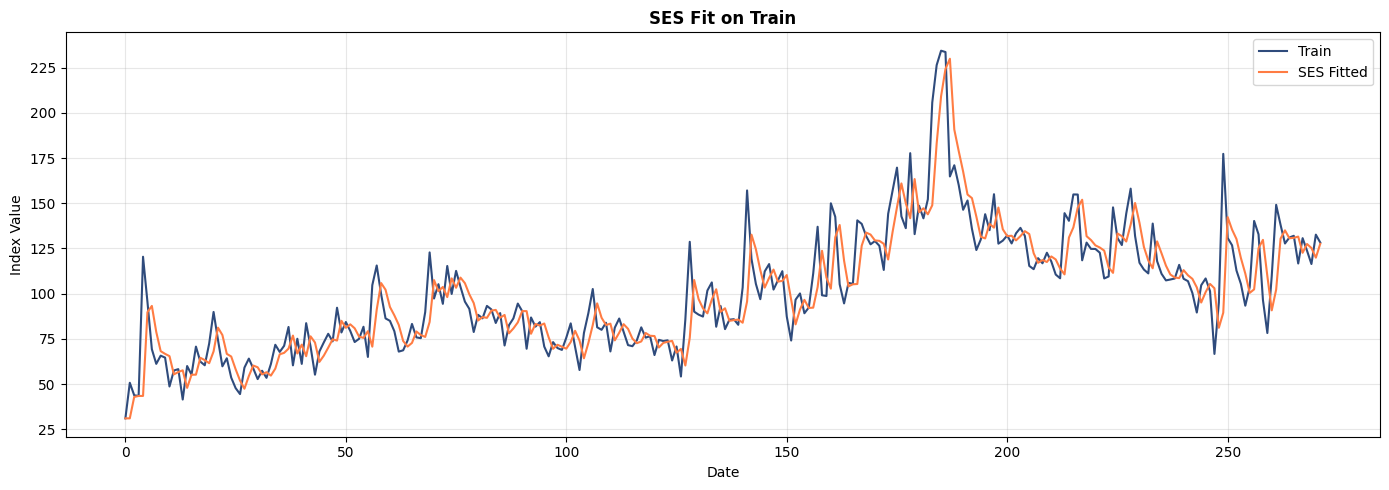

In [83]:

plt.figure(figsize=(14, 5))
plt.plot(train, color='#2f4b7c', label='Train')
plt.plot(fitted_train, color='#ff7c43', label='SES Fitted')
plt.title('SES Fit on Train', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

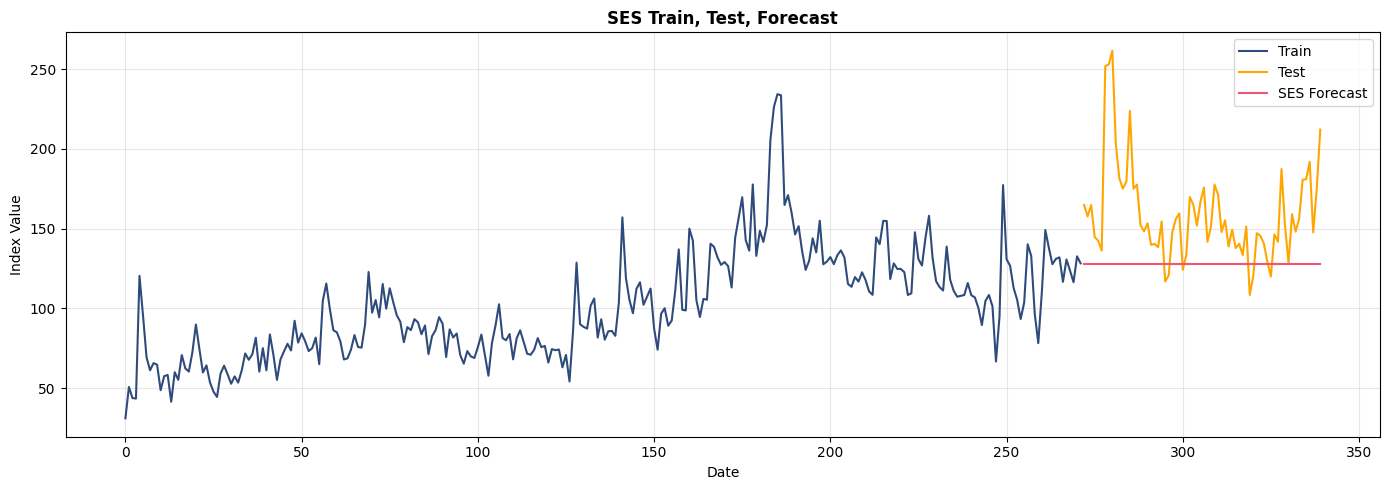

In [84]:
forecast = model.forecast(len(test))

plt.figure(figsize=(14, 5))
plt.plot(train, color='#2f4b7c', label='Train')
plt.plot(test, color='#ffa600', label='Test')
plt.plot(test.index, forecast, color='#ef5675', linestyle='-', label='SES Forecast')
plt.title('SES Train, Test, Forecast', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

##### 5.2.2. HOLT'S WINTER LINEAR TREND

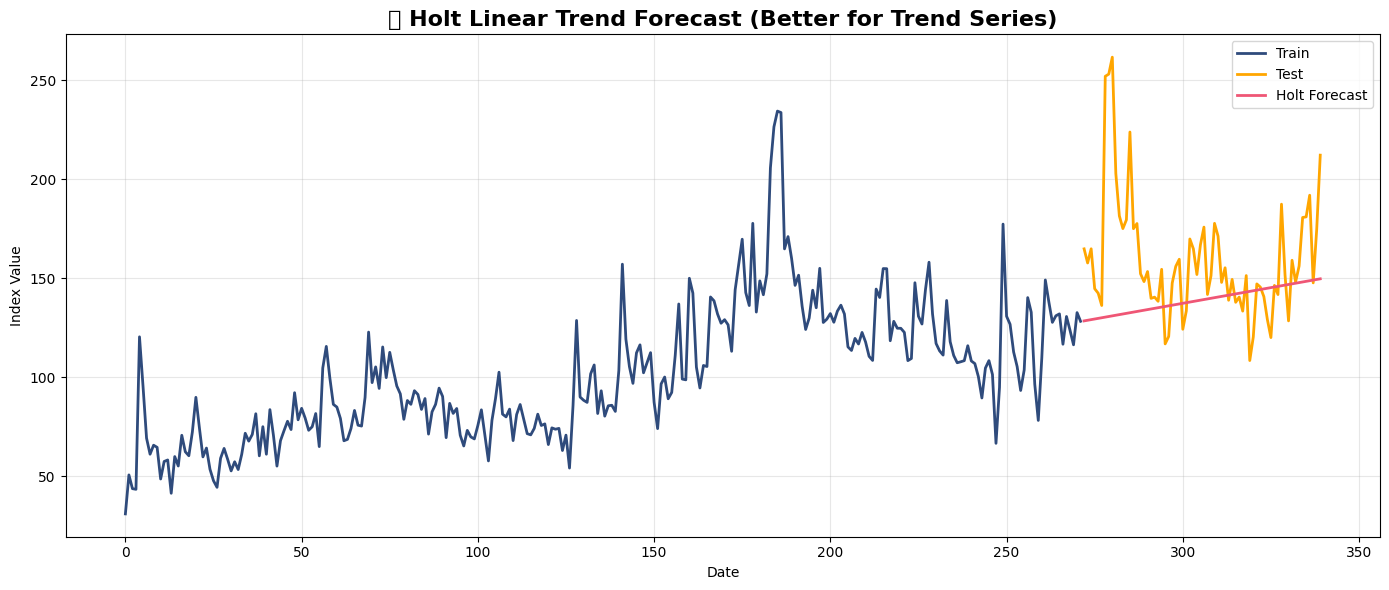

In [86]:
holt_model = ExponentialSmoothing(train, trend='add', seasonal=None).fit()

# Forecast trên test
holt_forecast = holt_model.forecast(len(test))

# Plot đẹp
plt.figure(figsize=(14, 6))
plt.plot(train.index, train, color='#2f4b7c', label='Train', linewidth=2)
plt.plot(test.index, test, color='#ffa600', label='Test', linewidth=2)
plt.plot(test.index, holt_forecast, color='#ef5675', linestyle='-', label='Holt Forecast', linewidth=2)

plt.title('✅ Holt Linear Trend Forecast (Better for Trend Series)', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

##### 5.2.3. HOLT'S WINTER SEASONAL

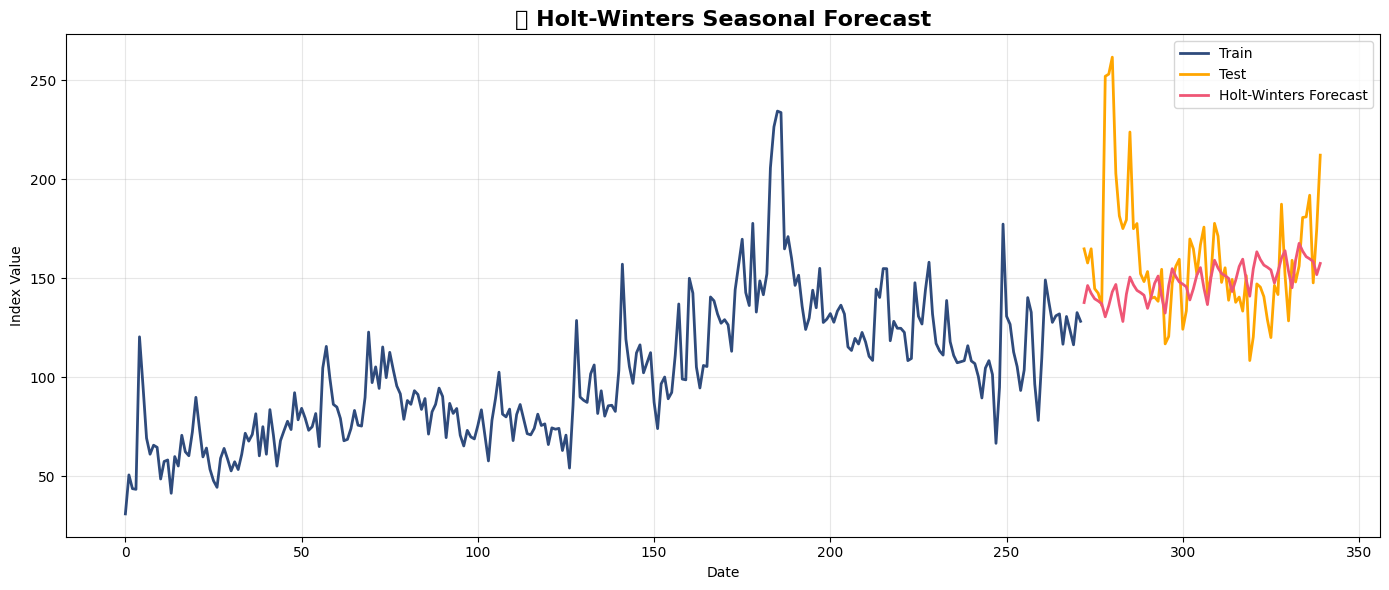

✅ Holt-Winters Test RMSE: 34.12


In [88]:
# Fit Holt-Winters Seasonal
hw_model = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()

# Forecast trên test
hw_forecast = hw_model.forecast(len(test))

# Plot
plt.figure(figsize=(14, 6))
plt.plot(train.index, train, color='#2f4b7c', label='Train', linewidth=2)
plt.plot(test.index, test, color='#ffa600', label='Test', linewidth=2)
plt.plot(test.index, hw_forecast, color='#ef5675', linestyle='-', label='Holt-Winters Forecast', linewidth=2)

plt.title('✅ Holt-Winters Seasonal Forecast', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Đánh giá RMSE
from sklearn.metrics import mean_squared_error
rmse_hw = np.sqrt(mean_squared_error(test, hw_forecast))
print(f"✅ Holt-Winters Test RMSE: {rmse_hw:.2f}")

#### 5.2. ARIMA

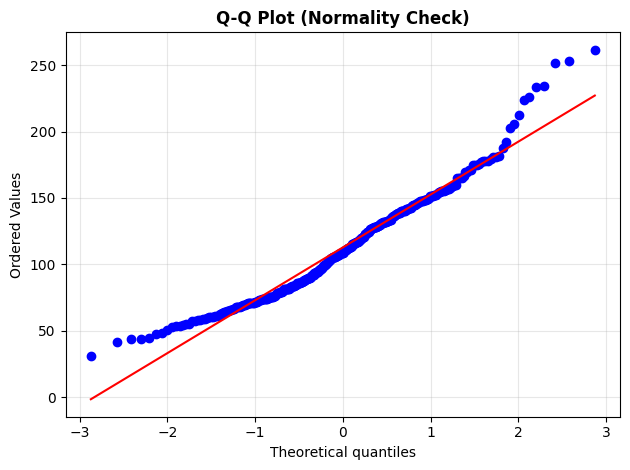

In [90]:
stats.probplot(df['Index value'], dist="norm", plot=plt)
plt.title('Q-Q Plot (Normality Check)', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [91]:
auto_arima_model = pm.auto_arima(
    df["Index value"],
    start_p=0, max_p=5,         
    d=1,                        
    start_q=0, max_q=5,        
    seasonal=False,             # disable seasonal
    information_criterion='aic',
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# 2. Kết quả
print(auto_arima_model.summary())

# 3. Lấy tham số tốt nhất
best_order_arima = auto_arima_model.order
print("Best ARIMA order:", best_order_arima)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2996.551, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2989.565, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2978.704, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2994.793, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2951.292, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2949.811, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2972.669, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2951.598, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2951.716, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2950.244, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2960.258, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2953.295, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2949.003, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2950.870, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]          

In [92]:
model_arima = ARIMA(df["Index value"], order=(2, 1, 2))
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            Index value   No. Observations:                  340
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1470.414
Date:                Fri, 27 Jun 2025   AIC                           2950.828
Time:                        21:56:39   BIC                           2969.958
Sample:                             0   HQIC                          2958.451
                                - 340                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6113      0.353      1.731      0.083      -0.081       1.303
ar.L2         -0.2336      0.180     -1.294      0.196      -0.587       0.120
ma.L1         -0.9072      0.360     -2.520      0.0

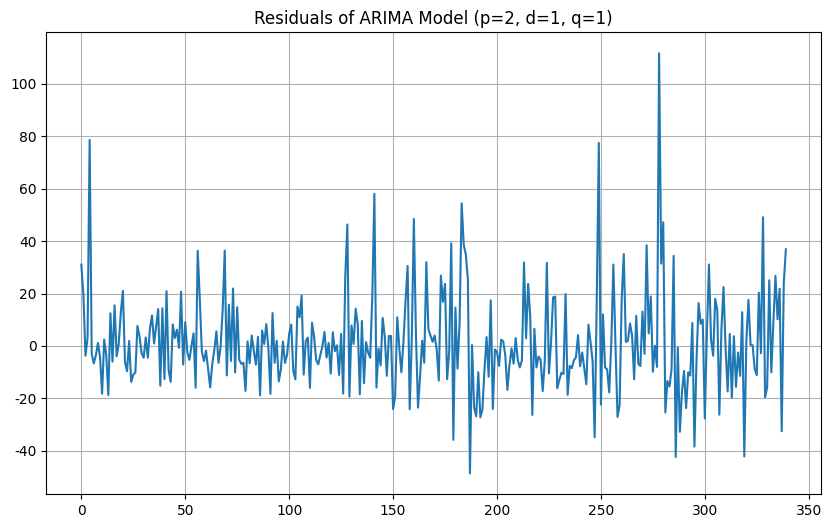

In [93]:
# Residual analysis
residuals = model_arima_fit.resid
plt.figure(figsize=(10, 6))

# Format y-axis
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, _: f'{int(x):,}'))

plt.plot(residuals)
plt.title('Residuals of ARIMA Model (p=2, d=1, q=1)')
plt.grid()
plt.show()

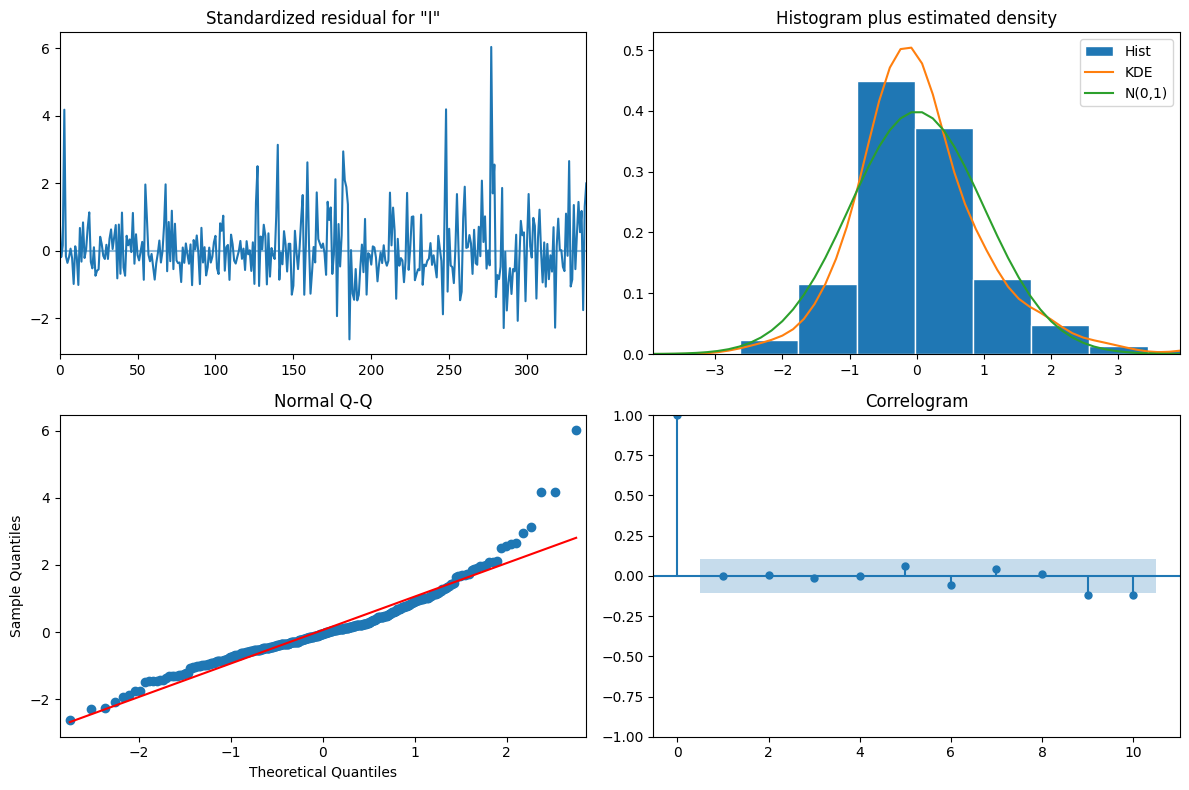

In [94]:
fc = model_arima_fit.get_forecast(steps=12)
y_pred = fc.predicted_mean
conf_int = fc.conf_int()
model_arima_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

train: 328  test: 12  pred: 12
ARIMA MAE  = 32.199
ARIMA RMSE = 1450.032


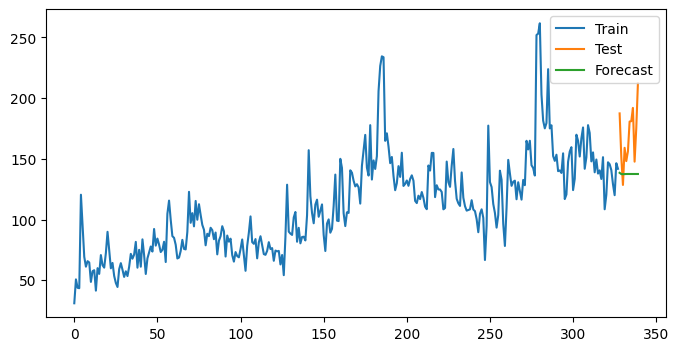

In [95]:
order = (2, 1, 1)  
y = df["Index value"]
train, test = y.iloc[:-12], y.iloc[-12:]
h = len(test)  #12
model = ARIMA(train, order=order).fit()


y_pred = model.forecast(steps=h)  
y_pred = pd.Series(y_pred.values, index=test.index)

print("train:", len(train), " test:", len(test), " pred:", len(y_pred))

mae  = mean_absolute_error(test, y_pred)
rmse = mean_squared_error(test, y_pred)
print(f"ARIMA MAE  = {mae:.3f}")
print(f"ARIMA RMSE = {rmse:.3f}")

plt.figure(figsize=(8,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test,   label='Test')
plt.plot(y_pred.index, y_pred, label='Forecast')
plt.legend()
plt.show()

#### 5.3. SARIMAX

In [97]:
auto_sarima_model = pm.auto_arima(
    df["Index value"],
    start_p=0, max_p=5,         
    d=1,                       
    start_q=0, max_q=5,        
    seasonal=True,             
    m=12,                      
    D=1,                      
    start_P=0, max_P=2,        
    start_Q=0, max_Q=2,         
    information_criterion='aic',
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)


print(auto_sarima_model.summary())


best_order_sarima        = auto_sarima_model.order
best_seasonal_order_sarima = auto_sarima_model.seasonal_order
print("Best SARIMA order:", best_order_sarima)
print("Best SARIMA seasonal_order:", best_seasonal_order_sarima)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3056.786, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2962.954, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3042.377, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2935.587, Time=0.23 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.77 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.60 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=2945.253, Time=0.18 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=2923.155, Time=0.37 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=2954.192, Time=0.18 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.06 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.40 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=2919.027, Time=0.41 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=2950.091, Time=0.26 sec
 ARIMA(3,1,0)(2,1,1)[12]             : AIC=i

In [98]:
model_sarimax = SARIMAX(
    endog=df["Index value"],
    order=(1, 1, 1),
    seasonal_order=(2, 1, 0, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_sarimax_fit = model_sarimax.fit(disp=False)
print(model_sarimax_fit.summary())

# Forecast
h = 12
fc = model_sarimax_fit.get_forecast(steps=h)


                                      SARIMAX Results                                      
Dep. Variable:                         Index value   No. Observations:                  340
Model:             SARIMAX(1, 1, 1)x(2, 1, [], 12)   Log Likelihood               -1341.031
Date:                             Fri, 27 Jun 2025   AIC                           2692.061
Time:                                     21:57:09   BIC                           2710.614
Sample:                                          0   HQIC                          2699.484
                                             - 340                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7592      0.038     20.010      0.000       0.685       0.834
ma.L1         -1.0000     1

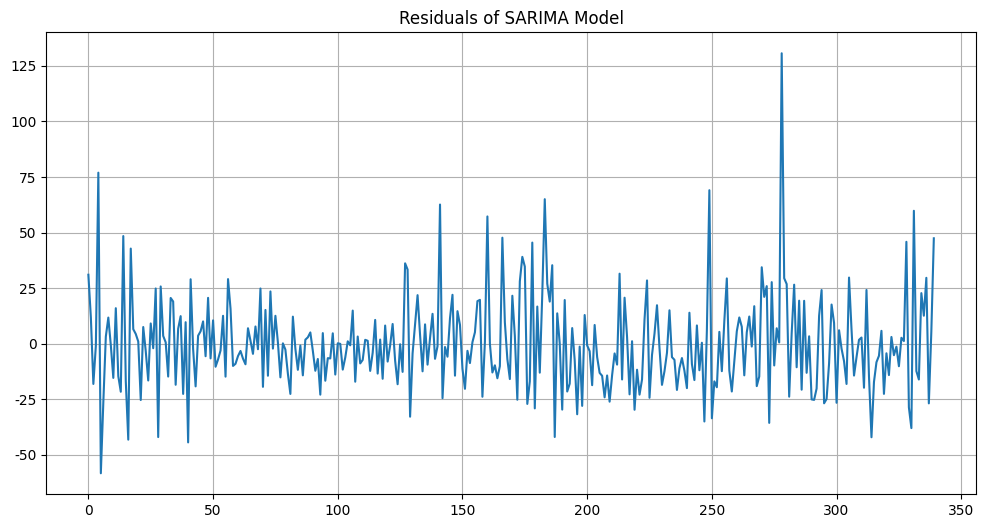

In [99]:
residuals = model_sarimax_fit.resid
plt.figure(figsize=(12, 6))

# Format y-axis
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, _: f'{int(x):,}'))

plt.plot(residuals)
plt.title('Residuals of SARIMA Model')
plt.grid()
plt.show()

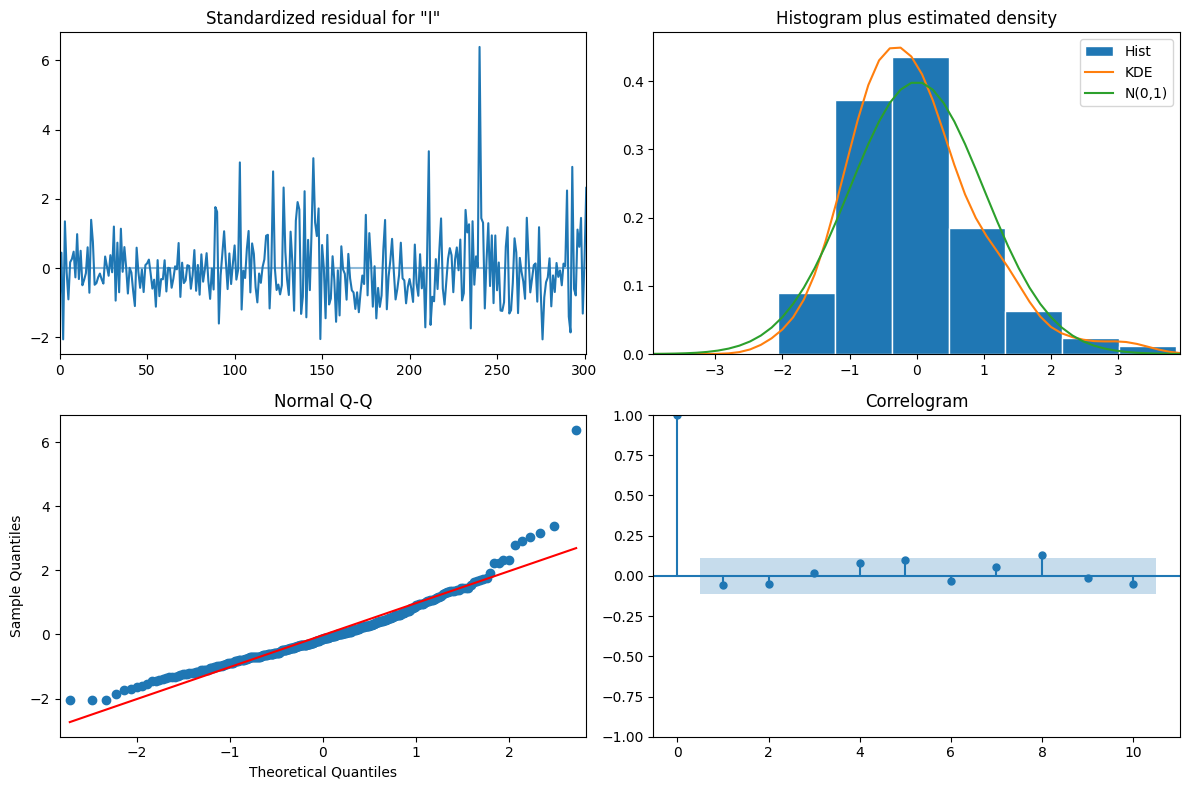

In [100]:
model_sarimax_fit = model_sarimax.fit(disp=False)
model_sarimax_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

In [101]:
order          = (1, 1, 1)         
seasonal_order = (2, 1, 0, 12)     
n_test         = 12      

In [102]:
y = df["Index value"]
test_size = 12
train = y[:-test_size]
test = y[-test_size:]


SARIMA MAE  = 40.559
SARIMA RMSE = 2032.289


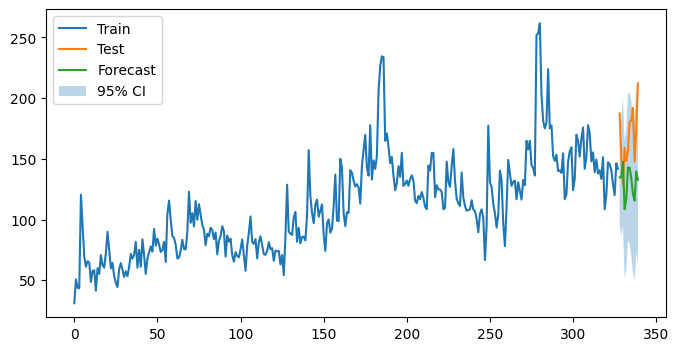

In [103]:
model = SARIMAX(
    endog          = train,
    order          = order,
    seasonal_order = seasonal_order,
    enforce_stationarity   = False,
    enforce_invertibility   = False
)
res = model.fit(disp=False)

fc      = res.get_forecast(steps=h)
y_pred  = fc.predicted_mean
ci      = fc.conf_int()


y_pred.index = test.index
ci.index     = test.index


mae  = mean_absolute_error(test, y_pred)
rmse = mean_squared_error(test, y_pred)
print(f"SARIMA MAE  = {mae:.3f}")
print(f"SARIMA RMSE = {rmse:.3f}")

# 6) Vẽ kết quả
plt.figure(figsize=(8,4))
plt.plot(train.index, train,     label='Train')
plt.plot(test.index,  test,      label='Test')
plt.plot(y_pred.index, y_pred,   label='Forecast')
plt.fill_between(
    ci.index,
    ci.iloc[:,0],
    ci.iloc[:,1],
    alpha=0.3,
    label='95% CI'
)
plt.legend()
plt.show()


Above Sarimax model can handle general trend, but cannot forecast large violaity, Hence we use grid search

In [105]:
p = [1, 2, 3]       
d = [1]             
q = [0, 1, 2]        
P = [1, 2, 3]       
D = [1]             
Q = [0, 1]          
m = 12             

In [106]:
parameter_combinations = list(itertools.product(p, d, q, P, D, Q))

In [107]:
results = []
for param in parameter_combinations:
    order = (param[0], param[1], param[2])
    seasonal_order = (param[3], param[4], param[5], m)
    try:
        model = SARIMAX(df["Index value"],
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        res = model.fit(disp=False)
   
        results.append((order, seasonal_order, res.aic))
        print(f"Tested SARIMAX{order} x {seasonal_order} → AIC={res.aic:.2f}")
    except Exception:
        continue

Tested SARIMAX(1, 1, 0) x (1, 1, 0, 12) → AIC=2843.51
Tested SARIMAX(1, 1, 0) x (1, 1, 1, 12) → AIC=2763.71
Tested SARIMAX(1, 1, 0) x (2, 1, 0, 12) → AIC=2712.78
Tested SARIMAX(1, 1, 0) x (2, 1, 1, 12) → AIC=2661.79
Tested SARIMAX(1, 1, 0) x (3, 1, 0, 12) → AIC=2595.92
Tested SARIMAX(1, 1, 0) x (3, 1, 1, 12) → AIC=2564.32
Tested SARIMAX(1, 1, 1) x (1, 1, 0, 12) → AIC=2821.30
Tested SARIMAX(1, 1, 1) x (1, 1, 1, 12) → AIC=2738.30
Tested SARIMAX(1, 1, 1) x (2, 1, 0, 12) → AIC=2692.06
Tested SARIMAX(1, 1, 1) x (2, 1, 1, 12) → AIC=2637.60
Tested SARIMAX(1, 1, 1) x (3, 1, 0, 12) → AIC=2576.10
Tested SARIMAX(1, 1, 1) x (3, 1, 1, 12) → AIC=2541.47
Tested SARIMAX(1, 1, 2) x (1, 1, 0, 12) → AIC=2819.98
Tested SARIMAX(1, 1, 2) x (1, 1, 1, 12) → AIC=2724.16
Tested SARIMAX(1, 1, 2) x (2, 1, 0, 12) → AIC=2693.09
Tested SARIMAX(1, 1, 2) x (2, 1, 1, 12) → AIC=2639.08
Tested SARIMAX(1, 1, 2) x (3, 1, 0, 12) → AIC=2574.14
Tested SARIMAX(1, 1, 2) x (3, 1, 1, 12) → AIC=2542.60
Tested SARIMAX(2, 1, 0) x (1

In [108]:
best_order, best_seasonal_order, best_aic = sorted(results, key=lambda x: x[2])[0]
print(f"Best order          = {best_order}")
print(f"Best seasonal_order = {best_seasonal_order}")
print(f"Best AIC            = {best_aic:.2f}")



Best order          = (3, 1, 1)
Best seasonal_order = (3, 1, 1, 12)
Best AIC            = 2529.45


In [109]:
final_model = SARIMAX(
    df['Index value'],
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
# Fit the model using the Powell optimization method to avoid convergence error
optimized_fit = final_model.fit(disp=False, method='powell')
print(optimized_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        Index value   No. Observations:                  340
Model:             SARIMAX(3, 1, 1)x(3, 1, 1, 12)   Log Likelihood               -1255.347
Date:                            Fri, 27 Jun 2025   AIC                           2528.694
Time:                                    21:58:40   BIC                           2561.660
Sample:                                         0   HQIC                          2541.905
                                            - 340                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2783      0.194      1.435      0.151      -0.102       0.658
ar.L2         -0.1259      0.073   

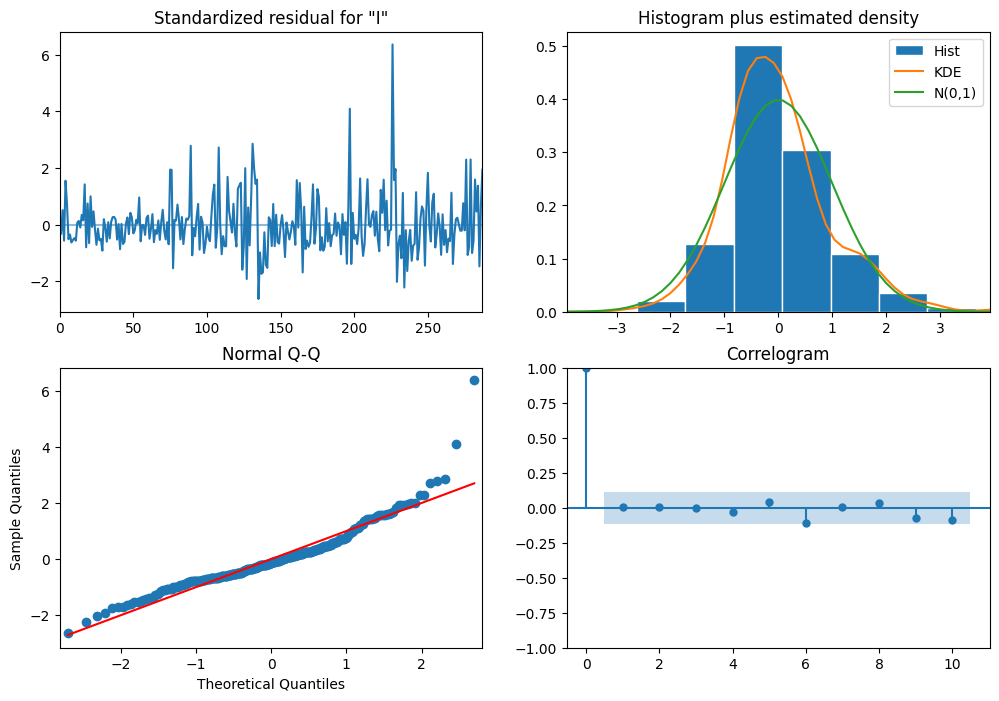

In [110]:
optimized_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

In [111]:
test_size = 12
train_data = df['Index value'][:-test_size]
test_data = df['Index value'][-test_size:]

# Train the SARIMA model on the training data
optimized_model = SARIMAX(train_data,
                          order=(3, 1, 1),  # Optimized non-seasonal parameters
                          seasonal_order=(3, 1, 1, 12),  # Optimized seasonal parameters
                          enforce_stationarity=False,
                          enforce_invertibility=False)

# Fit the model using the Powell method to avoid convergence warnings
optimized_fit = optimized_model.fit(method='powell', disp=False)

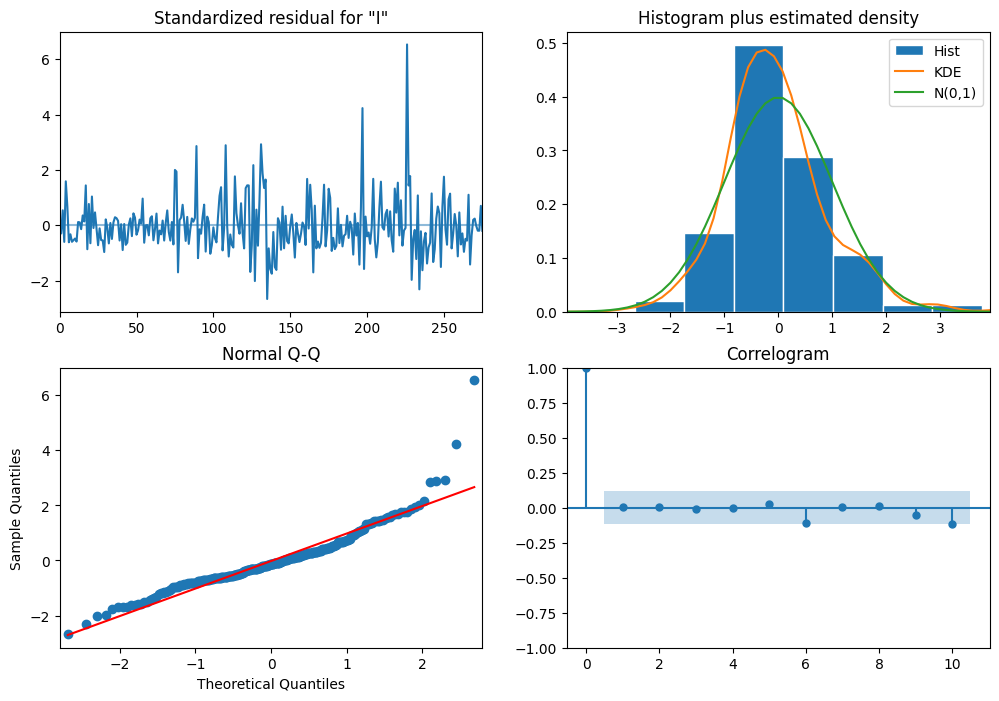

In [112]:
optimized_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

In [113]:
# Generate forecast for the test period
forecast = optimized_fit.get_forecast(steps=test_size)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

In [114]:
# Evaluate model performance
mae = mean_absolute_error(test_data, forecast_mean)
rmse = np.sqrt(mean_squared_error(test_data, forecast_mean))
mape = np.mean(np.abs((test_data - forecast_mean) / test_data)) * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 31.26
Root Mean Squared Error (RMSE): 37.00
Mean Absolute Percentage Error (MAPE): 17.52%


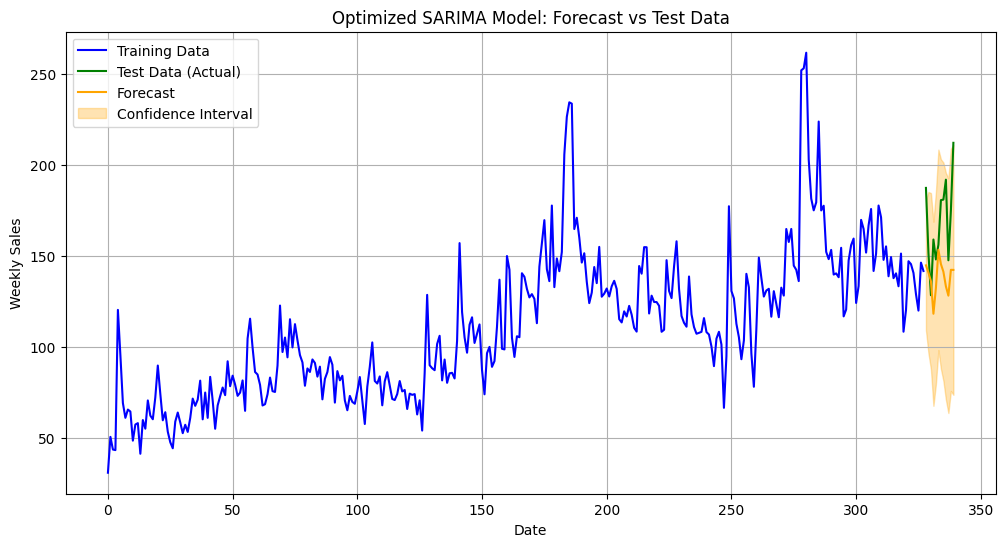

In [115]:
# Plot the forecast against the test data
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(train_data, label='Training Data', color='blue')

# Plot test data
plt.plot(test_data, label='Test Data (Actual)', color='green')

# Plot forecasted values
plt.plot(test_data.index, forecast_mean, label='Forecast', color='orange')

# Plot confidence intervals
plt.fill_between(test_data.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='orange', alpha=0.3, label='Confidence Interval')

# Format y-axis
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, _: f'{int(x):,}'))

plt.title('Optimized SARIMA Model: Forecast vs Test Data')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid()
plt.show()

#### 5.4. ARCH & GARCH

In [117]:
returns = df[['Date', 'Index value']].copy()
returns['y'] = returns['Index value'].pct_change().dropna()
returns = returns.dropna()[['Date', 'y']].rename(columns={'Date': 'ds'}); returns
returns['unique_id'] = 'epu index'
returns


,ds,y,unique_id
1,1997-02-01,0.634367,epu index
2,1997-03-01,-0.136911,epu index
3,1997-04-01,-0.007462,epu index
4,1997-05-01,1.772732,epu index
5,1997-06-01,-0.207043,epu index
...,...,...,...
335,2024-12-01,0.001676,epu index
336,2025-01-01,0.060401,epu index
337,2025-02-01,-0.230619,epu index
338,2025-03-01,0.184354,epu index


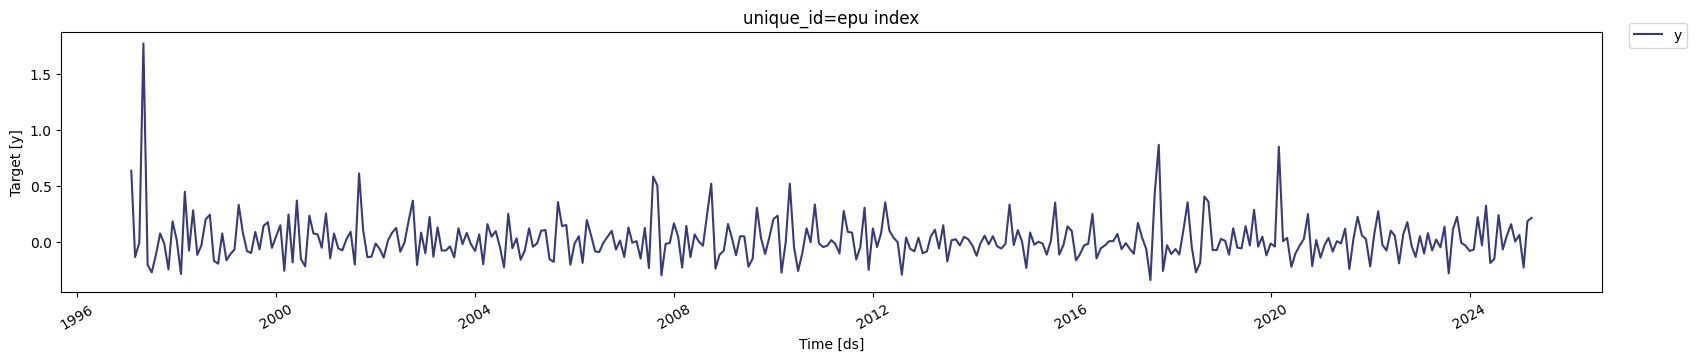

In [118]:
StatsForecast.plot(
    df=returns
)

In [119]:
y = df['Index value'].pct_change().dropna()
y = y * 100  

p_list = [1, 2, 3]      
q_list = [0, 1, 2]    
best = {'type':None, 'order':None, 'aic':np.inf}

warnings.filterwarnings("ignore")

for p in p_list:
    try:
        m = arch_model(y, mean='Constant', vol='ARCH', p=p, o=0, q=0, dist='normal')
        res = m.fit(disp='off')
        print(f"ARCH({p}) → AIC={res.aic:.2f}")
        if res.aic < best['aic']:
            best.update({'type':'ARCH', 'order':(p,), 'aic':res.aic})
    except Exception as e:
        print(f"  ARCH({p}) failed:", e)

for p, q in itertools.product(p_list, q_list):
    if q == 0: 
        continue  
    try:
        m = arch_model(y, mean='Constant', vol='GARCH', p=p, o=0, q=q, dist='normal')
        res = m.fit(disp='off')
        print(f"GARCH({p},{q}) → AIC={res.aic:.2f}")
        if res.aic < best['aic']:
            best.update({'type':'GARCH', 'order':(p,q), 'aic':res.aic})
    except Exception as e:
        print(f"  GARCH({p},{q}) failed:", e)

# 5. Kết quả
if best['type'] is not None:
    print("\n==> Best model:")
    print(f"  Type   : {best['type']}")
    print(f"  Order  : {best['order']}")
    print(f"  AIC    : {best['aic']:.2f}")
else:
    print("Cannot find best model, please check again p/q.")


ARCH(1) → AIC=2999.80
ARCH(2) → AIC=3000.79
ARCH(3) → AIC=2943.93
GARCH(1,1) → AIC=2939.89
GARCH(1,2) → AIC=2939.63
GARCH(2,1) → AIC=2941.89
GARCH(2,2) → AIC=2941.63
GARCH(3,1) → AIC=2943.89
GARCH(3,2) → AIC=2943.63

==> Best model:
  Type   : GARCH
  Order  : (1, 2)
  AIC    : 2939.63


In [120]:
models = [
    ARCH(1),
    GARCH(1,1),
    GARCH(1,2),
    Naive()
]

sf = StatsForecast(models=models, freq='MS', n_jobs=-1)

cv_df = sf.cross_validation(
    df        = returns,
    h         = 12,
    step_size = 12,
    n_windows = 4
)


In [121]:
cv_df.rename(columns = {'y' : 'actual'}, inplace = True)
cv_df.head()

,unique_id,ds,cutoff,actual,ARCH(1),"GARCH(1,1)","GARCH(1,2)",Naive
0,epu index,2021-05-01,2021-04-01,0.004400,0.327294,0.258311,0.326634,-0.088288
1,epu index,2021-06-01,2021-04-01,-0.014939,-0.134054,-0.119999,-0.135038,-0.088288
2,epu index,2021-07-01,2021-04-01,0.116784,-0.107414,-0.098487,-0.107582,-0.088288
3,epu index,2021-08-01,2021-04-01,-0.243733,-0.216938,-0.190016,-0.216689,-0.088288
4,epu index,2021-09-01,2021-04-01,0.032200,0.180562,0.162536,0.180976,-0.088288


This returns series is also get some volatility, so we need to use ARCH/GARCH model to forecast the volatility.

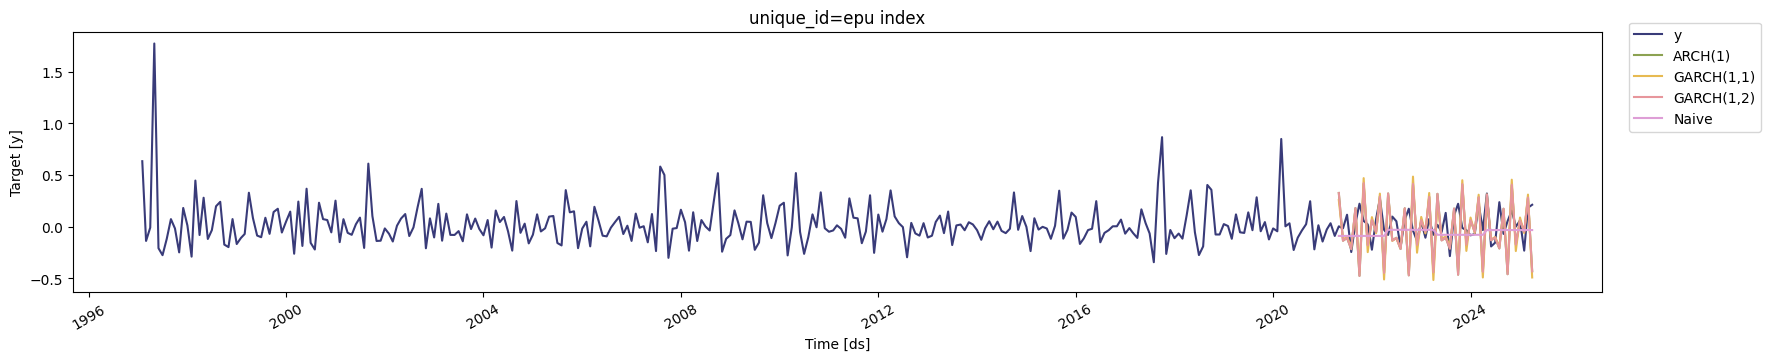

In [123]:
StatsForecast.plot(returns, cv_df.drop(['cutoff', 'actual'], axis=1))


In [124]:
model_cols = [col for col in cv_df.columns if col not in ['unique_id', 'ds', 'cutoff', 'actual']]

metrics = []
for model in model_cols:
    y_true = cv_df['actual']
    y_pred = cv_df[model]
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = (np.abs((y_true - y_pred) / y_true) * 100).mean()
    metrics.append({
        'Model': model,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE (%)': mape
    })

metrics_df = pd.DataFrame(metrics).set_index('Model')
print(metrics_df)

                RMSE       MAE    MAPE (%)
Model                                     
ARCH(1)     0.297584  0.227908  757.878094
GARCH(1,1)  0.307695  0.241640  834.143980
GARCH(1,2)  0.298768  0.228979  764.556452
Naive       0.164604  0.136963  233.825667


#### 5.0. XGBOOST

In [126]:
n_total = len(fe_df)
n_test = 12
n_valid = int(0.18 * n_total)      

# Index slice
train_end = n_total - n_valid - n_test
valid_end = n_total - n_test


In [127]:
X = fe_df.drop(columns=['Date', 'Index value'])
y = fe_df['Index value']

X_train = X.iloc[:train_end].copy()
y_train = y.iloc[:train_end].copy()

X_valid = X.iloc[train_end:valid_end].copy()
y_valid = y.iloc[train_end:valid_end].copy()

X_test = X.iloc[valid_end:].copy()
y_test = y.iloc[valid_end:].copy()

print(len(X_train), len(X_valid), len(X_test))



257 59 12


In [128]:
def filter_numeric(df):
    return df.select_dtypes(include=[np.number, 'bool'])

X_train = filter_numeric(X_train)
X_valid = filter_numeric(X_valid)
X_test  = filter_numeric(X_test)


In [129]:
params = {
    'n_estimators':     [100, 200],
    'max_depth':        [3, 4, 5],
    'learning_rate':    [0.01, 0.05, 0.1],
    'subsample':        [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha':        [0, 0.1, 0.5],
    'reg_lambda':       [1, 1.5, 2.0]
}

tscv = TimeSeriesSplit(n_splits=4)

model = XGBRegressor(objective='reg:squarederror', random_state=42)
clf = GridSearchCV(
    estimator  = model,
    param_grid = params,
    cv         = tscv,
    scoring    = 'neg_root_mean_squared_error',
    n_jobs     = -1,
    verbose    = 1
)

clf.fit(X_train, y_train)
print("Best params:", clf.best_params_)


Fitting 4 folds for each of 1458 candidates, totalling 5832 fits
Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.6}


In [130]:
best_params = clf.best_params_.copy()
final_model = XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

In [131]:
plt.figure(figsize=(14, 6))

plt.plot(dates_train, y_train, label='Training', color="#003f5c", linewidth=2)
plt.plot(dates_valid, y_valid, label='Validation', color="#bc5090", linewidth=2)
plt.plot(dates_test,  y_test,  label='Test', color="#ffa600", linewidth=2)

plt.title("EPU INDEX - Train Validation Test Split Visualization", fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


NameError: name 'dates_train' is not defined

<Figure size 1400x600 with 0 Axes>

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual', marker='o')
plt.plot(y_test.index, y_pred, label='XGBoost Forecast', marker='s')
plt.title('Test Set: Actual vs XGBoost Forecast')
plt.legend()
plt.show()

In [ ]:
xgb.plot_importance(final_model, max_num_features=15)   

In [ ]:
rmse_xgb = mean_squared_error(y_test, y_pred)
mae_xgb  = mean_absolute_error(y_test, y_pred)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"RMSE: {rmse_xgb:.3f}")
print(f"MAE : {mae_xgb:.3f}")
print(f"MAPE: {mape_xgb:.2f}%")

#### 5.5. LONG SHORT TERM MEMORY

In [ ]:
def create_sequences(series, window):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# Load và sort
series = fe_df['Index value'].values.reshape(-1,1)
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series).flatten()

window = 12    
tscv = TimeSeriesSplit(n_splits=5, test_size=12)

rmse_list, mae_list, mape_list = [], [], []

for train_idx, test_idx in tscv.split(series_scaled):
    train_seq = series_scaled[train_idx]
    test_seq  = series_scaled[test_idx]
    

    X_tr, y_tr = create_sequences(train_seq, window)
    X_te, y_te = create_sequences(
        np.concatenate([train_seq[-window:], test_seq]), window
    )
    
    X_tr = X_tr.reshape((X_tr.shape[0], X_tr.shape[1], 1))
    X_te = X_te.reshape((X_te.shape[0], X_te.shape[1], 1))
    
    model = Sequential([
        LSTM(50, activation='tanh', input_shape=(window,1)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    
    es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    model.fit(X_tr, y_tr, epochs=200, batch_size=16, verbose=0, callbacks=[es])
    
    y_pred_scaled = model.predict(X_te).flatten()
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
    y_true = scaler.inverse_transform(y_te.reshape(-1,1)).flatten()
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    rmse_list.append(rmse)
    mae_list.append(mae)
    mape_list.append(mape)

print("LSTM Backtest Results over folds:")
print(f"RMSE: {np.mean(rmse_list):.2f} ± {np.std(rmse_list):.2f}")
print(f"MAE : {np.mean(mae_list):.2f} ± {np.std(mae_list):.2f}")
print(f"MAPE: {np.mean(mape_list):.2f}% ± {np.std(mape_list):.2f}%")


In [ ]:

plt.figure(figsize=(10,5))
plt.plot(y_true, label='Actual', marker='o')
plt.plot(y_pred, label='LSTM Forecast', marker='s')
plt.title('LSTM: Actual vs Forecast')
plt.xlabel('Time index (test fold)')
plt.ylabel('EPU Index')
plt.legend()
plt.show()

In [ ]:
metrics = [
    {'Model':'XGBoost',          'RMSE':rmse_xgb,    'MAE':mae_xgb,    'MAPE':mape_xgb},
    {'Model':'Moving Average',   'RMSE':rmse_ma,     'MAE':mae_ma,     'MAPE':mape_ma},
    {'Model':'ARIMA',            'RMSE':rmse_arima,  'MAE':mae_arima,  'MAPE':mape_arima},
    {'Model':'SARIMAX',          'RMSE':rmse_sarimax,'MAE':mae_sarimax,'MAPE':mape_sarimax},
    {'Model':'ARCH',             'RMSE':rmse_arch,   'MAE':mae_arch,   'MAPE':mape_arch},
    {'Model':'GARCH',            'RMSE':rmse_garch,  'MAE':mae_garch,  'MAPE':mape_garch},
    {'Model':'LSTM',             'RMSE':rmse_lstm,   'MAE':mae_lstm,   'MAPE':mape_lstm},
]

total_metrics_df = pd.DataFrame(metrics)

total_metrics_df = total_metrics_df.sort_values('MAPE').reset_index(drop=True)

print(total_metrics_df)

### 6. REFERENCES

https://github.com/tphathuin1802/python-time-series/blob/main/notebook/projects/etf-price-prediction.ipynb

https://github.com/tphathuin1802/python-time-series/tree/main/notebook/deep_learning